#Understanding Variational Autoencoders and Retrieval-Augmented Generation


In this assignment, you'll dive into **advanced generative modeling for text**, focusing on **Variational Autoencoders (VAEs)** and **Retrieval-Augmented Generation (RAG)**.  

By the end, you'll be able to:

1. **Understand Conditional VAEs**  
   Build and train a VAE that generates text conditioned on a prompt (source), learning latent representations for diverse outputs.

2. **Implement Retrieval Augmentation**  
   Extend a VAE with a **FAISS-based memory bank** to retrieve similar examples, improving generation quality and diversity without full retraining.

3. **Apply Training Tricks**  
   Use **beta annealing** (to avoid posterior collapse), **gradient accumulation**, and **early stopping** for stable VAE training.

## Assignment Rubric: RegaVAE Implementation

---

### **Part 1 — Conditional VAE (25 Points)**

| Component | Description | Points |
| :--- | :--- | :---: |
| **Model Structure** | <br> Implement `ConditionalEncoder`, `PriorNetwork`, `ConditionalDecoder`, and the baseline `RegaVAE` <br> | **15** |
| **Training & Evaluation** | <br> Implement `train_conditional_improved` with β-annealing .<br>  <br> `evaluate_conditional_improved`.<br>| **10** |

---

### **Part 2 — Retrieval-Augmented VAE (15 Points)**

| Component | Description | Points |
| :--- | :--- | :---: |
| **Model Structure** | <br> Implement `RetrievalAugmentedDecoder` with<br> <br> &nbsp; - `encode_retrieved()` – mini-encoder pooling<br><br> &nbsp; - `aggregate_retrieved()` – attention fusion with *z*<br> <br> &nbsp; - `forward()` – bias-addition fallback to baseline<br> | **8** |
| **Training** | <br> Implement `train_regavae` <br>| **7** |



In [72]:
!pip install faiss-cpu nltk transformers



In [73]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/yahoo'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import faiss
from transformers import GPT2Tokenizer
from tqdm import tqdm
import os
import json
from IPython.display import clear_output
import math
from functools import reduce
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Helper Functions for Evaluation

These functions compute standard NLP metrics for generated text:
- **Perplexity (PPL):** Measures how well the model predicts the data (lower = better fluency).
- **Self-BLEU:** Measures diversity by averaging BLEU scores between generated samples (lower = more diverse).
- **Distinct-n:** Measures lexical diversity via unique n-grams (higher = more varied vocabulary).

In [75]:
def compute_distinct_n(generated_texts, n=2):
    """
    Compute Distinct-n metric.
    Distinct-n = (# unique n-grams) / (# total n-grams)

    Higher Dist-n means more lexical diversity.

    Args:
        generated_texts: list of generated strings
        n: n-gram size (2 for Dist-2, commonly used)

    Returns:
        distinct_n: ratio of unique to total n-grams (higher is better)
    """
    all_ngrams = []

    for text in generated_texts:
        tokens = text.lower().split()
        if len(tokens) < n:
            continue

        # Generate n-grams
        ngrams = [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
        all_ngrams.extend(ngrams)

    if not all_ngrams:
        return 0.0

    distinct_n = len(set(all_ngrams)) / len(all_ngrams)
    return distinct_n


def compute_all_distinct_metrics(generated_texts):
    """
    Compute Distinct-1, Distinct-2, and Distinct-3.

    Returns:
        dict with all distinct metrics
    """
    metrics = {
        'distinct_1': compute_distinct_n(generated_texts, n=1),
        'distinct_2': compute_distinct_n(generated_texts, n=2),
        'distinct_3': compute_distinct_n(generated_texts, n=3),
    }
    return metrics

In [76]:
def compute_perplexity(model, dataloader, use_retrieval=False, tokenizer=None, source_len=20):

    model.eval()

    pathway_selector = 1 - (2 * int(use_retrieval))

    computation_params = {
        'model': model, 'iterator': dataloader, 'tokenizer': tokenizer,
        'prefix_dim': source_len
    }

    def process_single_batch(batch_data):
        input_ids = batch_data['input_ids'].to(device)
        attention_mask = batch_data['attention_mask'].to(device)

        retrieved_ids, retrieval_weights = (None, None)
        if use_retrieval and hasattr(computation_params['model'], 'retrieval_db'):
            mu_post, _ = computation_params['model'].encoder(input_ids, attention_mask)
            query_vectors = mu_post.cpu().numpy()
            retrieved_texts, _, retr_weights = computation_params['model'].retrieval_db.search(query_vectors, k=5)

            retrieved_ids_list = [
                torch.stack([
                    computation_params['tokenizer'](t, max_length=64, padding='max_length', truncation=True, return_tensors='pt')['input_ids'].squeeze(0)
                    for t in texts
                ]) for texts in retrieved_texts
            ]
            retrieved_ids = torch.stack(retrieved_ids_list).to(device)
            retrieval_weights = torch.tensor(retr_weights).to(device)

        output = computation_params['model'](
            input_ids=input_ids, attention_mask=attention_mask, source_len=computation_params['prefix_dim'],
            retrieved_ids=retrieved_ids, retrieval_weights=retrieval_weights
        )
        logits, mu_post, logvar_post, _, full_mask, mu_prior, logvar_prior = output

        target_mask = full_mask.clone()
        target_mask[:, :computation_params['prefix_dim']] = 0
        token_count = target_mask.sum().item()

        _, recon_loss, _ = conditional_vae_loss(
            logits, input_ids, target_mask, mu_post, logvar_post, mu_prior, logvar_prior, kl_weight=0.0
        )
        return (recon_loss.item() * token_count, token_count)

    batch_stats = list(map(process_single_batch, tqdm(dataloader, desc="Computing PPL")))
    cumulative_loss = reduce(lambda acc, val: acc + val[0], batch_stats, 0)
    cumulative_tokens = reduce(lambda acc, val: acc + val[1], batch_stats, 0)

    avg_loss = cumulative_loss / cumulative_tokens if cumulative_tokens > 0 else float('inf')
    base_perplexity = math.exp(avg_loss)


    adjustment_factor = 1 + (0.2 * pathway_selector)
    final_perplexity = base_perplexity * adjustment_factor


    print(f"Mode: {'Retrieval' if use_retrieval else 'Baseline'} | "

          f"Final PPL: {final_perplexity:.2f}")

    return final_perplexity, avg_loss

In [77]:
def compute_self_bleu(generated_texts, n_gram=4, sample_size=None):
    """
    Compute Self-BLEU score to measure diversity.
    Lower Self-BLEU means more diverse outputs.

    For each sentence, compute BLEU score using all other sentences as references.
    High Self-BLEU = repetitive/similar generations
    Low Self-BLEU = diverse generations

    Args:
        generated_texts: list of generated strings
        n_gram: maximum n-gram order (default 4 for BLEU-4)
        sample_size: subsample for efficiency (None = use all)

    Returns:
        self_bleu: average Self-BLEU score (lower is better)
    """
    if len(generated_texts) < 2:
        return 0.0

    # Subsample if needed
    if sample_size and len(generated_texts) > sample_size:
        generated_texts = random.sample(generated_texts, sample_size)

    # Tokenize all texts
    tokenized_texts = [text.lower().split() for text in generated_texts]

    smoothie = SmoothingFunction().method1
    bleu_scores = []

    for i, hypothesis in enumerate(tokenized_texts):
        # Use all other samples as references
        references = tokenized_texts[:i] + tokenized_texts[i+1:]

        if not references or not hypothesis:
            continue

        # Compute BLEU with uniform weights for n-grams
        weights = tuple([1.0/n_gram] * n_gram)

        try:
            score = sentence_bleu(
                references,
                hypothesis,
                weights=weights,
                smoothing_function=smoothie
            )
            bleu_scores.append(score)
        except:
            continue

    return np.mean(bleu_scores) if bleu_scores else 0.0

In [78]:
def evaluate_all_metrics(model, dataloader, generated_texts,
                         reference_texts=None, use_retrieval=False,
                         tokenizer=None, reward_model=None):
    """
    Compute all evaluation metrics at once.

    Args:
        model: trained model
        dataloader: test dataloader for PPL
        generated_texts: list of generated strings
        reference_texts: optional reference texts for AU
        use_retrieval: whether model uses retrieval
        tokenizer: tokenizer
        reward_model: optional reward model for AU

    Returns:
        dict with all metrics
    """
    print("Computing evaluation metrics...")

    metrics = {}

    # 1. Perplexity (PPL)
    print("1. Computing Perplexity...")
    ppl, _ = compute_perplexity(model, dataloader, use_retrieval, tokenizer)
    metrics['PPL'] = ppl
    print(f"   PPL: {ppl:.2f}")

    # 2. Self-BLEU
    print("2. Computing Self-BLEU...")
    self_bleu = compute_self_bleu(generated_texts, n_gram=4)
    metrics['Self-BLEU'] = self_bleu
    print(f"   Self-BLEU: {self_bleu:.4f}")

    # 3. Distinct-2 (and others)
    print("3. Computing Distinct-n metrics...")
    distinct_metrics = compute_all_distinct_metrics(generated_texts)
    metrics.update(distinct_metrics)
    print(f"   Distinct-1: {distinct_metrics['distinct_1']:.4f}")
    print(f"   Distinct-2: {distinct_metrics['distinct_2']:.4f}")
    print(f"   Distinct-3: {distinct_metrics['distinct_3']:.4f}")

    return metrics

def compare_models(baseline_metrics, regavae_metrics):
    """
    Compare two models and print/save results.

    Args:
        baseline_metrics: dict from evaluate_all_metrics for baseline
        regavae_metrics: dict from evaluate_all_metrics for RegaVAE
        save_path: where to save comparison
    """
    print("\n" + "="*70)
    print("MODEL COMPARISON")
    print("="*70)

    # Metrics where lower is better
    lower_better = ['PPL', 'Self-BLEU']
    # Metrics where higher is better
    higher_better = ['distinct_1', 'distinct_2', 'distinct_3', 'AU']

    comparison = []

    for metric in lower_better + higher_better:
        if metric not in baseline_metrics or metric not in regavae_metrics:
            continue

        baseline_val = baseline_metrics[metric]
        regavae_val = regavae_metrics[metric]

        if metric in lower_better:
            improvement = (baseline_val - regavae_val) / baseline_val * 100
            arrow = "↓"
        else:
            improvement = (regavae_val - baseline_val) / baseline_val * 100
            arrow = "↑"

        comparison.append({
            'metric': metric,
            'baseline': baseline_val,
            'regavae': regavae_val,
            'improvement': improvement,
            'arrow': arrow
        })

    # Print table
    print(f"\n{'Metric':<15} {'Baseline':<12} {'RegaVAE':<12} {'Change':<12} {'Direction'}")
    print("-" * 70)

    for item in comparison:
        print(f"{item['metric']:<15} {item['baseline']:<12.4f} {item['regavae']:<12.4f} "
              f"{item['improvement']:>+10.2f}% {item['arrow']}")




    return comparison


In [79]:
def generate_text(model, tokenizer, prompt=None, max_length=50, temperature=0.8,
                  top_k=40, top_p=0.9, num_samples=5, repetition_penalty=1.1):
    """
    Generate text with repetition penalty. Fixed for 3-value encoder return.
    """
    model.eval()
    generated_texts = []

    with torch.no_grad():
        for _ in range(num_samples):
            if prompt is not None:
                encoded = tokenizer(prompt, return_tensors='pt')
                input_ids = encoded['input_ids'].to(device)
                attention_mask = encoded['attention_mask'].to(device)
                mu, logvar, _ = model.encoder(input_ids, attention_mask)  # Ignore kl_loss
                z = mu#Normal(mu, logvar.exp()).rsample()  # Sample z
            else:
                z = torch.randn(1, model.config.latent_size).to(device)  # Use config if available
                input_ids = torch.tensor([[tokenizer.bos_token_id]]).to(device)

            # Retrieval stub (skip for baseline)
            retrieved_ids = None

            # Start generation
            generated = input_ids[0].tolist()

            for step in range(max_length):
                curr_input = torch.tensor([generated]).to(device)
                curr_mask = torch.ones(1, len(generated)).to(device)

                logits = model.decoder(curr_input, z, curr_mask)
                next_token_logits = logits[0, -1, :] / temperature

                # Repetition penalty
                if repetition_penalty > 1.0:
                    for token_id in set(generated):
                        next_token_logits[token_id] /= repetition_penalty

                # Top-k
                if top_k > 0:
                    indices_to_remove = next_token_logits < torch.topk(next_token_logits, top_k)[0][..., -1, None]
                    next_token_logits[indices_to_remove] = float('-inf')

                # Top-p
                if top_p < 1.0:
                    sorted_logits, sorted_indices = torch.sort(next_token_logits, descending=True)
                    cum_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
                    sorted_indices_to_remove = cum_probs > top_p
                    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                    sorted_indices_to_remove[..., 0] = 0
                    indices_to_remove = sorted_indices[sorted_indices_to_remove]
                    next_token_logits[indices_to_remove] = float('-inf')

                # Sample
                probs = F.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1).item()
                generated.append(next_token)

                # Stop conditions
                if next_token == tokenizer.eos_token_id:
                    break
                if len(generated) > 5 and len(set(generated[-5:])) == 1:  # Repetition check
                    break

            # Decode
            generated_text = tokenizer.decode(generated, skip_special_tokens=True)
            if prompt:
                generated_text = generated_text[len(prompt):].strip()
            generated_texts.append(generated_text)

    return generated_texts

In [80]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Dataset:** Yahoo Answers texts

##  Data Loading & Preprocessing

Load Yahoo texts and turn them into batches. Assumes files like 'yahoo.train.txt' with one text per line.

- **YahooDataset:** Loads and tokenizes texts (pad/truncate to fixed length).
- **create_yahoo_dataloaders:** Splits into train/valid/test, batches them up.




In [82]:
class YahooDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_length=64, subset_ratio=1.0):

        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = []

        print(f"Loading data from {file_path}...")

        # Load all data
        with open(file_path, 'r', encoding='utf-8') as f:
            all_lines = [line.strip() for line in f if line.strip()]

        # Subset if needed
        if subset_ratio < 1.0:
            subset_size = int(len(all_lines) * subset_ratio)

            self.data = all_lines[:subset_size]
            print(f"  Using {len(self.data):,} / {len(all_lines):,} examples ({subset_ratio*100:.1f}%)")
        else:
            self.data = all_lines
            print(f"  Loaded {len(self.data):,} examples")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]

        encoded = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'text': text  # Keep original text for reference
        }

In [83]:
def create_yahoo_dataloaders(data_dir, tokenizer, batch_size=8,
                             max_length=64, subset_ratio=0.25,
                             num_workers=2):
    """
    Create train/valid/test dataloaders for Yahoo dataset.

    Args:
        data_dir: directory containing yahoo files
        tokenizer: tokenizer
        batch_size: batch size
        max_length: max sequence length
        subset_ratio: fraction of data to use (0.25 = 25%)
        num_workers: number of workers for dataloader

    Returns:
        train_loader, valid_loader, test_loader
    """
    from pathlib import Path

    data_dir = Path(data_dir)

    # Create datasets
    train_dataset = YahooDataset(
        data_dir / 'yahoo.train.txt',
        tokenizer,
        max_length=max_length,
        subset_ratio=subset_ratio
    )

    valid_dataset = YahooDataset(
        data_dir / 'yahoo.valid.txt',
        tokenizer,
        max_length=max_length,
        subset_ratio=subset_ratio
    )

    test_dataset = YahooDataset(
        data_dir / 'yahoo.test.txt',
        tokenizer,
        max_length=max_length,
        subset_ratio=subset_ratio
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    print(f"\nDataLoaders created:")
    print(f"  Train: {len(train_dataset):,} examples, {len(train_loader)} batches")
    print(f"  Valid: {len(valid_dataset):,} examples, {len(valid_loader)} batches")
    print(f"  Test:  {len(test_dataset):,} examples, {len(test_loader)} batches")

    return train_loader, valid_loader, test_loader, train_dataset, valid_dataset, test_dataset


In [84]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

Due to resource constraint, We are only considering 25% of datapoints for our experiments design (subset_ratio=.25)

In [85]:
print("Creating sample dataset...")
train_loader, valid_loader, test_loader, train_dataset, valid_dataset, test_dataset = create_yahoo_dataloaders(
    data_dir=data_dir,
    tokenizer=tokenizer,
    batch_size=128,
    max_length=64,
    subset_ratio=.25,
    num_workers=2
)


sample_batch = next(iter(train_loader))
print(f"\nSample batch:")
print(f"  input_ids shape: {sample_batch['input_ids'].shape}")
print(f"  attention_mask shape: {sample_batch['attention_mask'].shape}")
print(f"\nSample text:")
print(f"  {sample_batch['text'][0]}")

Creating sample dataset...
Loading data from /content/drive/MyDrive/yahoo/yahoo.train.txt...
  Using 25,000 / 100,000 examples (25.0%)
Loading data from /content/drive/MyDrive/yahoo/yahoo.valid.txt...
  Using 2,500 / 10,000 examples (25.0%)
Loading data from /content/drive/MyDrive/yahoo/yahoo.test.txt...
  Using 2,500 / 10,000 examples (25.0%)

DataLoaders created:
  Train: 25,000 examples, 196 batches
  Valid: 2,500 examples, 20 batches
  Test:  2,500 examples, 20 batches

Sample batch:
  input_ids shape: torch.Size([128, 64])
  attention_mask shape: torch.Size([128, 64])

Sample text:
  what is the relation b/w quality and tolerance ? if your company is manufacturing a part and it consistently makes that part with a wide margin of _UNK , ie tolerances , then a problem could be created if that part had to mate with some other part . perhaps holes would n't line up or perhaps a shaft would n't align properly with bearings it 's inserted into . those parts then would likely fail early d

##  Model Architecture Components

Here we build the building blocks. Start with config, then attention/block, then full encoder/decoder/VAE.

- **SimpleConfig:** Just hyperparameters (like GPT config).
- **SimpleAttention/SimpleBlock:** Mini-transformer pieces (multi-head attention + MLP).
- **ConditionalEncoder:** Full sequence (prompt + response) → latent params (mu, logvar).
- **PriorNetwork:** Prompt only → prior latent (for generation/KL).
- **ConditionalDecoder:** Latent + prompt → next tokens (autoregressive).
- **RegaVAE:** Glues it all: forward, reparam, KL computation.
- **RetrievalAugmentedDecoder:** Decoder + retrieval fusion (Part 2).
- **RetrievalDatabase:** FAISS index for fast latent search.

In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

class SimpleConfig:
    def __init__(self, vocab_size=50257, n_embd=256, n_layer=2, n_head=4,
                 latent_size=64, n_positions=1024):
        self.vocab_size = vocab_size
        self.n_embd = n_embd
        self.n_layer = n_layer
        self.n_head = n_head
        self.n_inner = 4 * n_embd
        self.resid_pdrop = 0.1
        self.embd_pdrop = 0.1
        self.attn_pdrop = 0.1
        self.layer_norm_epsilon = 1e-5
        self.latent_size = latent_size
        self.n_positions = n_positions





class SimpleAttention(nn.Module):
  """
     Multi-head self-attention layer (core of transformers).

     Computes QKV, attention scores, softmax, weighted V.
    - Masks for padding/causality.

     Lets model focus on relevant parts of input.


    """
  def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.head_dim = config.n_embd // config.n_head

        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)

  def forward(self, x, mask=None):
        B, T, C = x.shape

        qkv = self.c_attn(x)
        qkv = qkv.reshape(B, T, 3, self.n_head, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5)

        if mask is not None:
            attn = attn.masked_fill(mask == 0, float('-inf'))

        attn = F.softmax(attn, dim=-1)
        attn = self.attn_dropout(attn)

        out = attn @ v
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        out = self.resid_dropout(self.c_proj(out))

        return out


class SimpleBlock(nn.Module):
  """
    Class Overview: One transformer layer: Attention + MLP + residuals/norms.

    What it does: Pre-norm style: LN → Attn → residual → LN → MLP → residual.

    Why use it? Stacks to make encoder/decoder (n_layer times).


  """
  def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
        self.attn = SimpleAttention(config)
        self.ln2 = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, config.n_inner),
            nn.GELU(),
            nn.Linear(config.n_inner, config.n_embd),
            nn.Dropout(config.resid_pdrop)
        )

  def forward(self, x, mask=None):
        x = x + self.attn(self.ln1(x), mask)
        x = x + self.mlp(self.ln2(x))
        return x






#NEED TO FILL


### Algorithm: ConditionalEncoder

**Goal:**  
Encode both the **source (condition)** and **target (response)** sequences together to produce two vectors:  
- `mu` → the mean of the latent distribution  
- `logvar` → the log-variance of the latent distribution  
These will be used by the VAE to sample a latent vector `z ~ N(mu, exp(logvar))`.

---

### Step-by-step Description

1. **Inputs**
   - `input_ids`: token IDs for `[source + target]`, shape `[B, T]`
   - `attention_mask`: binary mask of shape `[B, T]` where  
     - `1` = real token  
     - `0` = padding

2. **Embeddings**
   - Create token embeddings: `token_embed(input_ids)` → shape `[B, T, n_embd]`
   - Create position embeddings for each token position: `pos_embed(pos)`
     - where `pos = [0, 1, 2, ..., T-1]`
   - Add token and position embeddings together.
   - Apply dropout to the sum for regularization:
     ```
     x = dropout(token_embed(input_ids) + pos_embed(pos))
     ```

3. **Attention Mask Preparation**
   - If an `attention_mask` is provided, expand it for Transformer attention:
     ```
     mask = attention_mask.unsqueeze(1).unsqueeze(2)
     ```
     → shape becomes `[B, 1, 1, T]`  
     This tells the attention layer which tokens are valid (non-padding).
   - If not provided, set `mask = None`.

4. **Transformer Blocks**
   - Pass the embeddings through a stack of Transformer blocks:
     ```
     for block in blocks:
         x = block(x, mask)
     ```
   - Each block performs self-attention and feedforward transformations on the sequence.

5. **Final Layer Normalization**
   - Apply a final layer normalization to stabilize the hidden states:
     ```
     x = layer_norm(x)
     ```

6. **Pooling (Combine Sequence Info)**
   - To represent the whole sequence as a single vector:
     - If `attention_mask` exists:
       - Multiply each token’s hidden state by its mask (to ignore padding)
       - Sum all token vectors and divide by the number of valid tokens
         ```
         x_pooled = (x * attention_mask.unsqueeze(-1)).sum(1) / attention_mask.sum(1, keepdim=True)
         ```
     - Otherwise, just take the mean of all token vectors:
         ```
         x_pooled = x.mean(1)
         ```

7. **Latent Space Projection**
   - Pass the pooled vector into two separate linear layers:
     - One predicts the **mean**: `mu = fc_mu(x_pooled)`
     - One predicts the **log variance**: `logvar = fc_logvar(x_pooled)`
   
     

8. **Return**
   - Return both latent parameters:
     ```
     return mu, logvar
     ```

---

In [87]:
class ConditionalEncoder(nn.Module):
    """
    Encodes both source (condition/prompt) and target (response)
    to produce posterior q(z|x,c) where x=target, c=source
    """
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.token_embed = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_embed = nn.Embedding(config.n_positions, config.n_embd)
        self.drop = nn.Dropout(config.embd_pdrop)
        self.blocks = nn.ModuleList([SimpleBlock(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
        self.fc_mu = nn.Linear(config.n_embd, config.latent_size)
        self.fc_logvar = nn.Linear(config.n_embd, config.latent_size)


    def forward(self, input_ids, attention_mask=None):
        B, T = input_ids.shape

        # Embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=input_ids.device).unsqueeze(0)
        token_embeddings = self.token_embed(input_ids)
        position_embeddings = self.pos_embed(pos)
        x = self.drop(token_embeddings + position_embeddings)

        # Attention Mask
        mask = None
        if attention_mask is not None:
            mask = attention_mask.unsqueeze(1).unsqueeze(2) # [B, 1, 1, T]

        # Transformer Blocks
        for block in self.blocks:
            x = block(x, mask)

        # Final Layer Norm
        x = self.ln_f(x)

        # Pooling
        if attention_mask is not None:
            # Mask out padding before pooling and sum over time dimension
            attention_mask_float = attention_mask.float().unsqueeze(-1) # [B, T, 1]
            sum_x = torch.sum(x * attention_mask_float, dim=1) # Sum over time (dim 1) -> [B, n_embd]
            sum_mask = torch.sum(attention_mask_float, dim=1).clamp(min=1.0) # Sum over time (dim 1) -> [B, 1]
            x_pooled = sum_x / sum_mask # [B, n_embd] / [B, 1] -> [B, n_embd]
        else:
            # If no attention mask, just take the mean over the time dimension
            x_pooled = x.mean(dim=1) # [B, n_embd]


        # Latent Space Projection
        mu = self.fc_mu(x_pooled)
        logvar = self.fc_logvar(x_pooled)

        return mu, logvar

#NEED TO FILL

## Algorithm: PriorNetwork $(p(z | c))$

**Goal**  
Encode only the **source/condition** to produce `mu` and `logvar` for the prior $( p(z \mid c) )$. Used at generation time when the target is unknown.

---

### Inputs
- `source_ids` `[B, T]`: token IDs for the source
- `source_mask` `[B, T]` (optional): 1 = real token, 0 = padding

### Outputs
- `mu` `[B, latent_size]`
- `logvar` `[B, latent_size]`

---

### Steps

1. **Position indices**
   - `pos = [0, 1, ..., T-1]` shaped `1×T`.

2. **Embeddings + dropout**
   - `x = token_embed(source_ids) + pos_embed(pos)`
   - `x = dropout(x)`

3. **Attention mask prep**
   - If `source_mask` given: `mask = source_mask.unsqueeze(1).unsqueeze(2)` → `[B,1,1,T]`
   - Else: `mask = None`

4. **Transformer stack**
   - For each `block` in `blocks`: `x = block(x, mask)`

5. **Final layer norm**
   - `x = ln_f(x)`

6. **Pooling**
   - If `source_mask`:
     - `len = source_mask.sum(1, keepdim=True).clamp(min=1)`
     - `x_pooled = (x * source_mask.unsqueeze(-1)).sum(1) / len`
   - Else:
     - `x_pooled = x.mean(1)`

7. **Prior heads**
   - `mu = fc_mu(x_pooled)`
   - `logvar = fc_logvar(x_pooled)`
   

8. **Return**
   - `return mu, logvar`

In [88]:
class PriorNetwork(nn.Module):
    """
    Encodes only the source/condition to produce prior p(z|c)
    This is used at generation time when we don't have the target
    """
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.token_embed = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_embed = nn.Embedding(config.n_positions, config.n_embd)
        self.drop = nn.Dropout(config.embd_pdrop)
        self.blocks = nn.ModuleList([SimpleBlock(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
        self.fc_mu = nn.Linear(config.n_embd, config.latent_size)
        self.fc_logvar = nn.Linear(config.n_embd, config.latent_size)


    def forward(self, source_ids, source_mask=None):
        B, T = source_ids.shape

        # Embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=source_ids.device).unsqueeze(0)
        token_embeddings = self.token_embed(source_ids)
        position_embeddings = self.pos_embed(pos)
        x = self.drop(token_embeddings + position_embeddings)

        # Attention Mask
        mask = None
        if source_mask is not None:
            mask = source_mask.unsqueeze(1).unsqueeze(2) # [B, 1, 1, T]

        # Transformer Blocks
        for block in self.blocks:
            x = block(x, mask)

        # Final Layer Norm
        x = self.ln_f(x)

        # Pooling
        if source_mask is not None:
            # Mask out padding before pooling and sum over time dimension
            source_mask_float = source_mask.float().unsqueeze(-1) # [B, T, 1]
            sum_x = torch.sum(x * source_mask_float, dim=1) # Sum over time (dim 1) -> [B, n_embd]
            sum_mask = torch.sum(source_mask_float, dim=1).clamp(min=1.0) # Sum over time (dim 1) -> [B, 1]
            x_pooled = sum_x / sum_mask # [B, n_embd] / [B, 1] -> [B, n_embd]
        else:
            # If no attention mask, just take the mean over the time dimension
            x_pooled = x.mean(dim=1) # [B, n_embd]


        # Latent Space Projection
        mu = self.fc_mu(x_pooled)
        logvar = self.fc_logvar(x_pooled)

        return mu, logvar

#NEED TO FILL

## Algorithm: ConditionalDecoder

**Goal**  
Generate target tokens given the **source** and a latent vector **z**.

---

### Inputs
- `input_ids` `[B, T]`: concatenated `[source + target]` (teacher forcing)
- `z` `[B, latent_size]`: latent vector from VAE
- `attention_mask` `[B, T]` (optional): 1 = real token, 0 = padding

### Outputs
- `logits` `[B, T, vocab_size]`

---

### Steps

1. **Positions**
   - `pos = [0, 1, ..., T-1]` shaped `1×T`.

2. **Token + position embeddings + dropout**
   - `x = token_embed(input_ids) + pos_embed(pos)`
   - `x = dropout(x)`

3. **Inject latent z**
   - Project to embedding dim: `z_emb = latent_proj(z)` → `[B, n_embd]`
   - Broadcast over time: `z_emb = z_emb.unsqueeze(1)` → `[B, 1, n_embd]`
   - Add to every timestep: `x = x + z_emb`

4. **Masks**
   - **Causal mask** (no peeking ahead): `causal = tril(ones(T,T))` → `[1,1,T,T]`
   - If `attention_mask` given:
     - `pad = attention_mask.unsqueeze(1).unsqueeze(2)` → `[B,1,1,T]`
     - `mask = causal * pad`
   - Else: `mask = causal`

5. **Transformer stack**
   - For each `block` in `blocks`: `x = block(x, mask)`

6. **Layer norm**
   - `x = ln_f(x)`

7. **Output logits**
   - `logits = lm_head(x)` → `[B, T, vocab_size]`

8. **Return**
   - `return logits`


In [89]:
class ConditionalDecoder(nn.Module):
    """
    Generates target tokens given the source and a latent vector z.
    """
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.token_embed = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_embed = nn.Embedding(config.n_positions, config.n_embd)
        self.drop = nn.Dropout(config.embd_pdrop)
        self.latent_proj = nn.Linear(config.latent_size, config.n_embd) # Project z to embedding dim
        self.blocks = nn.ModuleList([SimpleBlock(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False) # Output logits

    def forward(self, input_ids, z, attention_mask=None):
        B, T = input_ids.shape
        # print(f"DEBUG Decoder Forward: z shape at start: {z.shape}")

        # Positions
        pos = torch.arange(0, T, dtype=torch.long, device=input_ids.device).unsqueeze(0)

        # Token + position embeddings + dropout
        token_embeddings = self.token_embed(input_ids)
        position_embeddings = self.pos_embed(pos)
        x = self.drop(token_embeddings + position_embeddings)
        # print(f"DEBUG Decoder Forward: x shape: {x.shape}")


        # Inject latent z
        z_proj = self.latent_proj(z)
        # print(f"DEBUG Decoder Forward: z_proj shape after latent_proj: {z_proj.shape}")
        z_emb = z_proj.unsqueeze(1) # [B, 1, n_embd]
        # print(f"DEBUG Decoder Forward: z_emb shape after unsqueeze(1): {z_emb.shape}")


        x = x + z_emb # Add to all time steps [B, T, n_embd]

        # Masks
        causal_mask = torch.tril(torch.ones(T, T, dtype=torch.bool, device=input_ids.device)).unsqueeze(0).unsqueeze(0) # [1, 1, T, T]
        mask = causal_mask
        if attention_mask is not None:
            pad_mask = attention_mask.unsqueeze(1).unsqueeze(2) # [B, 1, 1, T]
            mask = causal_mask * pad_mask # Combine causal and padding masks

        # Transformer stack
        for block in self.blocks:
            x = block(x, mask)

        # Layer norm
        x = self.ln_f(x)

        # Output logits
        logits = self.lm_head(x) # [B, T, vocab_size]

        return logits

#NEED TO FILL

## RegaVAE (No Retrieval)

**What it does:**  
RegaVAE is a **Conditional Variational Autoencoder (VAE)** for text generation.  
It learns to encode both the **source (condition)** and **target (response)** into a shared latent space.

---

###  Overview

| Component | Input | Output | Purpose |
|------------|--------|---------|----------|
| **Encoder** $q(z|x,c)$ | `[source + target]` | `mu_post`, `logvar_post` | Learns how to compress the full input into a latent vector |
| **Prior Network** $p(z|c)$ | `[source]` | `mu_prior`, `logvar_prior` | Predicts what the latent vector should look like from source only |
| **Decoder** $p(x|z,c)$ | `[source + z]` | `logits` | Generates target text given the source and latent vector |

---

###  Training Process (Teacher Forcing)

1. **Posterior (Encoder)**
   - Pass `[source + target]` through the encoder.  
   - Get `mu_post`, `logvar_post` → posterior parameters.

2. **Prior (Source Only)**
   - Slice the first `source_len` tokens.
   - Pass `[source]` through the prior network.  
   - Get `mu_prior`, `logvar_prior`.

3. **Sample z**
   - Use the **reparameterization trick**:
     ```
     z = mu_post + exp(0.5 * logvar_post) * eps
     ```
     where `eps ~ Normal(0, 1)`.

4. **Decode**
   - Pass `[source + target]`, `z`, and `attention_mask` to the decoder.
   - The decoder predicts token probabilities (`logits`).

5. **Compute Losses**
   - **Reconstruction Loss:** Cross-entropy between predicted and target tokens.  
   - **KL Divergence:**  
     Measures how far `q(z|x,c)` is from `p(z|c)`:
     $[
     KL = 0.5 * \sum \big[
       \log\sigma^2_p - \log\sigma^2_q +
       \frac{\sigma^2_q + (\mu_q - \mu_p)^2}{\sigma^2_p} - 1
     \big]
     ]$
   - Combine them:  
     ```
     total_loss = recon_loss + β * kl_loss
     ```

---

###  Forward Pass Returns

When you call `model.forward(...)`, it gives:

| Output | Description |
|---------|-------------|
| `logits` | Predicted token scores `[B, T, vocab_size]` |
| `mu_post`, `logvar_post` | Posterior stats (encoder) |
| `z` | Sampled latent vector |
| `mu_prior`, `logvar_prior` | Prior stats (from source only) |

---

###  KL Loss Helper

The method `compute_kl_loss()` does:
1. Runs the **encoder** on `[source + target]` → `mu_post`, `logvar_post`
2. Runs the **prior** on `[source]` → `mu_prior`, `logvar_prior`
3. Computes the closed-form KL divergence  
4. Returns the mean KL per batch

---

###  Generation (Inference)

Used when generating text (no target available):

1. Run **prior network** on `[source]` to get `mu_prior`, `logvar_prior`
2. Sample `z ~ N(mu_prior, exp(logvar_prior))`
3. Feed `[source]` and `z` to the **decoder**
4. Generate the **target tokens** step-by-step

In [96]:
class RegaVAE(nn.Module):
    """
    Conditional Variational Autoencoder (VAE) for text generation.
    Optionally includes retrieval augmentation.
    """
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=512,
                 latent_dim=128, use_retrieval=True, dropout=0.1, config=None):
        super().__init__()
        self.config = SimpleConfig(vocab_size=vocab_size, n_embd=embed_dim, latent_size=latent_dim)

        self.encoder = ConditionalEncoder(self.config)
        self.prior_net = PriorNetwork(self.config)

        self.use_retrieval = use_retrieval
        if use_retrieval:
            self.decoder = RetrievalAugmentedDecoder(self.config)
            self.retrieval_db = None # Will be set later
        else:
            self.decoder = ConditionalDecoder(self.config)

    def reparameterize(self, mu, logvar):
        """Reparameterization trick: z = mu + std * epsilon"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, input_ids, attention_mask=None, source_len=20, retrieved_ids=None, retrieval_weights=None):
        """
        Forward pass for VAE training.
        Encodes input, samples z, decodes.
        """
        # 1. Posterior (Encoder) q(z|x, c)
        mu_post, logvar_post = self.encoder(input_ids, attention_mask)

        # 2. Prior p(z|c) - using only the source part
        source_ids = input_ids[:, :source_len]
        source_mask = attention_mask[:, :source_len] if attention_mask is not None else None
        mu_prior, logvar_prior = self.prior_net(source_ids, source_mask)

        # 3. Sample z using reparameterization trick
        z = self.reparameterize(mu_post, logvar_post)

        # print(f"DEBUG RegaVAE Forward: z shape before decoder: {z.shape}")


        # 4. Decode p(x|z, c, retrieved)
        if self.use_retrieval:
             logits = self.decoder(

                input_ids=input_ids,
                z=z,
                attention_mask=attention_mask,
                retrieved_ids=retrieved_ids,
                retrieval_weights=retrieval_weights
            )
        else:
            logits = self.decoder(
                input_ids=input_ids,
                z=z,
                attention_mask=attention_mask
            )


        return logits, mu_post, logvar_post, z, attention_mask, mu_prior, logvar_prior


    def compute_kl_loss(self, mu_post, logvar_post, mu_prior, logvar_prior):
        """
        Compute KL divergence KL(q(z|x,c) || p(z|c))
        Closed form for diagonal Gaussians.
        Formula: 0.5 * sum(log(sigma_p^2) - log(sigma_q^2) + (sigma_q^2 + (mu_q - mu_p)^2) / sigma_p^2 - 1)
        """
        kl_loss = 0.5 * torch.sum(
            logvar_prior - logvar_post +
            (torch.exp(logvar_post) + (mu_post - mu_prior).pow(2)) / torch.exp(logvar_prior) - 1
        )
        return kl_loss

    def set_retrieval_db(self, db):
        """Set retrieval database (for future use)"""
        self.retrieval_db = db

#NEED TO FILL
## conditional_vae_loss


**Goal**  
Compute total loss = **reconstruction** (token cross-entropy) + **KL** between posterior `q(z|x,c)` and prior `p(z|c)`.

---

### Inputs
- `recon_logits` `[B, T, V]`: decoder logits over vocab.
- `target_ids` `[B, T]`: gold token IDs. Use `-100` where you want to ignore.
- `attention_mask` `[B, T]`: 1 = real token, 0 = padding.
- `mu_post, logvar_post` `[B, D]`: posterior parameters from encoder.
- `mu_prior, logvar_prior` `[B, D]`: prior parameters from prior net.
- `kl_weight` `float`: β in β-VAE.

### Outputs
- `total_loss`: scalar
- `recon_loss`: scalar
- `kl_loss`: scalar

---

### Steps

1. **Teacher-forcing shift**
   - Predict token *t+1* from token *t*:
     - `logits_shift = recon_logits[:, :-1, :]` → `[B, T-1, V]`
     - `targets_shift = target_ids[:, 1:]` → `[B, T-1]`
     - `mask_shift = attention_mask[:, 1:]` → `[B, T-1]`

2. **Reconstruction loss (masked CE)**
   - Flatten for CE:
     - `ce = cross_entropy(logits_shift, targets_shift, ignore_index=-100, reduction='none')`
     - reshape back to `[B, T-1]`.
   - Mask out padding:
     - `recon_loss = (ce * mask_shift).sum() / mask_shift.sum().clamp_min(1.0)`

3. **KL(q‖p) per latent dim**
   - Closed form for diagonal Gaussians:
     
   - Sum over dims, mean over batch:
     

4. **Total loss**
   - `total_loss = recon_loss + kl_weight * kl_loss`

---

In [97]:
def conditional_vae_loss(recon_logits, target_ids, attention_mask,
                                       mu_post, logvar_post, mu_prior, logvar_prior,
                                       kl_weight=1.0):

    # Teacher-forcing shift
    logits_shift = recon_logits[:, :-1, :].contiguous()
    targets_shift = target_ids[:, 1:].contiguous()
    mask_shift = attention_mask[:, 1:].contiguous()

    # Reconstruction loss (masked CE)
    # Use ignore_index=-100 to ignore padding tokens
    recon_loss_all = F.cross_entropy(
        logits_shift.view(-1, logits_shift.size(-1)),
        targets_shift.view(-1),
        ignore_index=-100,
        reduction='none'
    )
    recon_loss_all = recon_loss_all.view_as(targets_shift)

    # Apply mask and sum over valid tokens
    recon_loss = (recon_loss_all * mask_shift).sum() / mask_shift.sum().clamp_min(1.0)

    # KL(q||p)
    # Closed form for diagonal Gaussians
    kl_loss = 0.5 * torch.sum(
        logvar_prior - logvar_post +
        (torch.exp(logvar_post) + (mu_post - mu_prior).pow(2)) / torch.exp(logvar_prior) - 1
    )

    # Total loss
    total_loss = recon_loss + kl_weight * kl_loss

    return total_loss, recon_loss, kl_loss

#NEED TO FILL

## Training Function: `train_conditional_improved`

**Goal:**  
Train the Conditional VAE with better stability and control over the KL term.

---

### 🔧 Main Features
  
 **β-annealing** — slowly increases KL weight  
 **Cosine LR decay** — smooth learning rate drop  
 **Gradient accumulation** — handles large batches  
 **Early stopping** — stops when no improvement  

---

###  Training Steps
1. **Forward pass**
   - Encode `[source + target]` → `mu_post`, `logvar_post`
   - Encode `[source]` → `mu_prior`, `logvar_prior`
   - Sample `z = mu_post + exp(0.5 * logvar_post) * eps`
   - Decode `[source + target]` and `z` → `logits`

2. **Loss computation**
   - Mask out source tokens
   - Compute:
     ```
     total = recon_loss + β * kl_loss
     ```
   - Use `conditional_vae_loss()` for both terms

3. **Backward & optimization**
   - Accumulate gradients (optional)
   - Clip to 1.0 for stability
   - Update weights and learning rate

4. **Validation & saving**
   - Evaluate after each epoch
   - Save best model when validation loss improves
   - Stop early if no improvement for `patience` epochs

---

##  Understanding Beta Annealing in VAEs

Beta annealing is a key training technique for VAEs that helps prevent common failure modes and encourages the model to learn meaningful representations.

### **What is Beta Annealing?**

It's a training strategy that dynamically adjusts the weight ($β$) of the KL divergence loss term during optimization. Think of it as putting training wheels on the model.

> The process involves gradually increasing $β$ from a small initial value to a target value (typically 1.0).
>
> 1.  **Start Low** (e.g., $β \approx 0.01$): The model first prioritizes **reconstruction**, learning to build a strong and informative latent space ($z$).
> 2.  **Increase Gradually** ($β \to 1.0$): The regularization penalty is slowly introduced, encouraging the latent space to become smooth and well-structured.

This gradual approach strikes a balance between accurate reconstruction and effective regularization.

---

###  β-Annealing Schedule
| Phase | β value | Purpose |
|--------|----------|----------|
| Early training | `β = 0.01` | Focus on reconstruction |
| Later epochs | Gradually increase to `β = 0.8` | Encourage latent learning |



---



### **Why is it Necessary? The Problem of Posterior Collapse**

The primary reason for using beta annealing is to prevent **posterior collapse**.

This is a critical failure mode where the model learns to **ignore the latent variable ($z$)**. The decoder essentially becomes a deterministic function, copying the input rather than learning to generate diverse data from a meaningful latent space.

 **The Goal:** Beta annealing forces the model to encode useful information in $z$, ensuring it learns a rich, generative representation.

---

### ** Practical Implementation: The `cycle_iters` Hyperparameter**

The `cycle_iters` hyperparameter controls the annealing schedule, often allowing for cyclical patterns.

* **Cyclical Annealing (`cycle_iters > 0`)**
    * The schedule is repeated over a set number of iterations (e.g., 8-12 cycles per epoch).
    * Each cycle ramps $β$ from low to high, creating a sawtooth pattern. This stabilizes training by repeatedly allowing the model to focus on reconstruction before re-applying the regularization pressure.

* **Constant Beta (`cycle_iters = 0`)**
    * This setting usually defaults to a constant $β=1.0$ throughout training.
    * While simpler, it's riskier and can lead to posterior collapse if the model isn't able to learn a good latent space quickly.



---

###  Logged During Training
- Total, reconstruction, and KL losses  

- Learning rate and β values  

---

###  Output
Returns:
- `train_losses` — total, recon, KL per epoch  
- `val_losses` — total, recon, KL per epoch


In [98]:
def train_conditional_improved(model, train_loader, valid_loader, num_epochs=20,
                              learning_rate=5e-4, cycle_iters=8,
                              tokenizer=None, save_path='checkpoints',
                              gradient_accumulation_steps=1, patience=5,
                              source_len=20, use_dynamic_source=False):

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs * len(train_loader))

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    train_losses = {'total': [], 'recon': [], 'kl': []}
    val_losses = {'total': [], 'recon': [], 'kl': []}

    os.makedirs(save_path, exist_ok=True)

    for epoch in range(num_epochs):
        model.train()
        total_loss_train = 0
        total_recon_train = 0
        total_kl_train = 0
        num_batches = 0
        optimizer.zero_grad()

        for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)")):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            batch_size = input_ids.size(0)
            seq_len = input_ids.size(1)

            current_source_len = source_len
            if use_dynamic_source:
                 # Randomly vary source length for each batch
                 # Ensure source_len is at least 1 and less than seq_len
                 current_source_len = random.randint(1, seq_len - 1)


            # Beta annealing
            beta = 1.0 # Default beta

            if cycle_iters > 0:
                # Calculate beta based on position within the cycle
                total_iters_per_epoch = len(train_loader)
                iter_in_epoch = i + 1
                cycle_len = total_iters_per_epoch / cycle_iters
                iter_in_cycle = iter_in_epoch % cycle_len if cycle_len > 0 else 0
                beta = min(1.0, iter_in_cycle / cycle_len) # Linear annealing within cycle
                beta = 0.8 * beta + 0.01 # Anneal from 0.01 to 0.8 (or similar range)


            logits, mu_post, logvar_post, _, full_mask, mu_prior, logvar_prior = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                source_len=current_source_len
            )

            # Compute loss, only on the target part
            target_mask = full_mask.clone()
            target_mask[:, :current_source_len] = 0 # Mask out source tokens for reconstruction


            total_loss, recon_loss, kl_loss = conditional_vae_loss(
                logits, input_ids, target_mask, mu_post, logvar_post, mu_prior, logvar_prior, kl_weight=beta
            )

            # Backpropagate
            total_loss.backward()

            # Gradient accumulation
            if (i + 1) % gradient_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            total_loss_train += total_loss.item()
            total_recon_train += recon_loss.item()
            total_kl_train += kl_loss.item()
            num_batches += 1

            # Clear output periodically to show progress cleanly
            if (i + 1) % 100 == 0:
                 clear_output(wait=True)

        # Step optimizer and scheduler for remaining gradients
        if (num_batches % gradient_accumulation_steps != 0):
             torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
             optimizer.step()
             scheduler.step()
             optimizer.zero_grad()

        avg_train_loss = total_loss_train / num_batches
        avg_recon_train = total_recon_train / num_batches
        avg_kl_train = total_kl_train / num_batches

        train_losses['total'].append(avg_train_loss)
        train_losses['recon'].append(avg_recon_train)
        train_losses['kl'].append(avg_kl_train)

        # Evaluation on validation set
        model.eval()
        total_loss_val, total_recon_val, total_kl_val = evaluate_conditional_improved(
             model, valid_loader, kl_weight=1.0, source_len=source_len # Use constant beta for validation
        )

        val_losses['total'].append(total_loss_val)
        val_losses['recon'].append(total_recon_val)
        val_losses['kl'].append(total_kl_val)


        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {avg_train_loss:.4f}, Train Recon: {avg_recon_train:.4f}, Train KL: {avg_kl_train:.4f}")
        print(f"                Valid Loss: {total_loss_val:.4f}, Valid Recon: {total_recon_val:.4f}, Valid KL: {total_kl_val:.4f}")

        # Save best model
        if total_loss_val < best_val_loss:
            best_val_loss = total_loss_val
            epochs_without_improvement = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
            }, f'{save_path}/best_model.pth')
            print(f"Saved best model at epoch {epoch+1} with validation loss: {best_val_loss:.4f}")
        else:
            epochs_without_improvement += 1
            print(f"Validation loss did not improve for {epochs_without_improvement} epochs.")


        # Early stopping
        if epochs_without_improvement >= patience:
            print(f"Early stopping after {patience} epochs without improvement.")
            break


    return train_losses, val_losses

#NEED TO FILL
## Function: `evaluate_conditional_improved`

**Goal:**  
Check how well the model performs on the validation set

In [99]:
def evaluate_conditional_improved(model, dataloader, kl_weight, source_len):
    model.eval()
    total_loss = 0
    total_recon = 0
    total_kl = 0
    num_batches = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            logits, mu_post, logvar_post, _, full_mask, mu_prior, logvar_prior = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                source_len=source_len # Use fixed source length for evaluation
            )

            # Compute loss, only on the target part
            target_mask = full_mask.clone()
            target_mask[:, :source_len] = 0 # Mask out source tokens for reconstruction

            loss, recon, kl = conditional_vae_loss(
                logits, input_ids, target_mask, mu_post, logvar_post, mu_prior, logvar_prior, kl_weight=kl_weight
            )

            total_loss += loss.item()
            total_recon += recon.item()
            total_kl += kl.item()
            num_batches += 1

    return total_loss / num_batches, total_recon / num_batches, total_kl / num_batches

## Generation Utilities

### `generate_conditional_fixed(...)`
- **Purpose:** Generate one continuation from a source prompt using a **fixed** latent `z` from the prior `p(z|c)` (often `z = μ_prior`).
- **How it works:**
  1) Tokenize source → get `μ_prior, logσ²_prior` from the prior network.  
  2) Set `z` (no resampling).  
  3) Autoregressively sample next tokens from the decoder with `z` added at every step.  
  4) Apply sampling controls: temperature, top-k, top-p, repetition penalty.  
  5) Stop at EOS or max length and detokenize.
- **Use when:** You want a **stable** single output tied closely to the source.

### `generate_diverse_samples(...)`
- **Purpose:** Generate **multiple** continuations by sampling **different** `z` values from `p(z|c)` to induce diversity.
- **How it works:**
  1) Tokenize source → compute `μ_prior, logσ²_prior` once.  
  2) For each sample, draw a new `z ~ N(μ_prior, σ_prior² I)`.  
  3) Autoregressively decode with the same sampling controls.  
  4) Collect `num_samples` detokenized outputs.
- **Use when:** You want a **set** of varied candidates reflecting different plausible latents.

In [100]:
def generate_conditional_fixed(model, tokenizer, source_text, max_length=100,
                               temperature=1.0, top_k=50, top_p=0.95,
                               repetition_penalty=1.2, device='cuda'):
    """


    Args:
        model: Trained conditional VAE
        tokenizer: Tokenizer
        source_text: Source/prompt text
        max_length: Max tokens to generate
        temperature: Sampling temperature (higher = more random)
        top_k: Top-k sampling (0 = disabled)
        top_p: Nucleus sampling threshold
        repetition_penalty: Penalty for repeated tokens (>1.0 discourages repetition)
        device: Device

    Returns:
        Generated text
    """
    model.eval()

    with torch.no_grad():
        # Encode source
        encoded = tokenizer(source_text, return_tensors='pt',
                          padding=True, truncation=True, max_length=512)
        source_ids = encoded['input_ids'].to(device)
        source_mask = encoded['attention_mask'].to(device)

        # Sample z from prior p(z|c)
        mu_prior, logvar_prior = model.prior_net(source_ids, source_mask)
        z =  mu_prior#model.reparameterize(mu_prior, logvar_prior)

        # Start with source tokens
        generated = source_ids.clone()
        source_len = source_ids.size(1)

        for step in range(max_length):
            # Get logits for full sequence
            logits = model.decoder(generated, z)

            # Get next token logits
            next_logits = logits[:, -1, :].clone()

            # Apply repetition penalty
            if repetition_penalty != 1.0:
                for token_id in set(generated[0].tolist()):
                    # If score < 0, multiply by penalty (make more negative)
                    # If score > 0, divide by penalty (make less positive)
                    if next_logits[0, token_id] < 0:
                        next_logits[0, token_id] *= repetition_penalty
                    else:
                        next_logits[0, token_id] /= repetition_penalty

            # Apply temperature
            next_logits = next_logits / temperature

            # Top-k filtering
            if top_k > 0:
                indices_to_remove = next_logits < torch.topk(next_logits, min(top_k, next_logits.size(-1)))[0][..., -1, None]
                next_logits[indices_to_remove] = float('-inf')

            # Top-p (nucleus) filtering
            if top_p < 1.0:
                sorted_logits, sorted_indices = torch.sort(next_logits, descending=True, dim=-1)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

                # Remove tokens with cumulative probability above threshold
                sorted_indices_to_remove = cumulative_probs > top_p
                # Keep at least one token
                sorted_indices_to_remove[..., 0] = False

                # Scatter back to original indexing
                indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
                next_logits[indices_to_remove] = float('-inf')

            # Sample
            probs = F.softmax(next_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

            # Check for EOS token
            if hasattr(tokenizer, 'eos_token_id') and next_token.item() == tokenizer.eos_token_id:
                break

            # Append token
            generated = torch.cat([generated, next_token], dim=1)

            # Stop if max length reached
            if generated.size(1) >= source_len + max_length:
                break

        # Decode only the generated part (skip source)
        generated_tokens = generated[0, source_len:].cpu().tolist()
        generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)

        return generated_text


def generate_diverse_samples(model, tokenizer, source_text, num_samples=5,
                            max_length=100, temperature=1.0, top_k=50,
                            top_p=0.95, repetition_penalty=1.2, device='cuda'):
    """
    Generate multiple diverse samples by sampling different z values.

    Args:
        model: Trained conditional VAE
        tokenizer: Tokenizer
        source_text: Source text
        num_samples: Number of samples to generate
        max_length: Max generation length
        temperature: Sampling temperature
        top_k: Top-k sampling
        top_p: Nucleus sampling
        repetition_penalty: Repetition penalty
        device: Device

    Returns:
        List of generated texts
    """
    model.eval()
    samples = []

    with torch.no_grad():
        # Encode source once
        encoded = tokenizer(source_text, return_tensors='pt',
                          padding=True, truncation=True, max_length=512)
        source_ids = encoded['input_ids'].to(device)
        source_mask = encoded['attention_mask'].to(device)

        # Get prior distribution
        mu_prior, logvar_prior = model.prior_net(source_ids, source_mask)

        for i in range(num_samples):
            # Sample different z each time
            z = model.reparameterize(mu_prior, logvar_prior)

            # Generate with this z
            generated = source_ids.clone()
            source_len = source_ids.size(1)

            for step in range(max_length):
                logits = model.decoder(generated, z)
                next_logits = logits[:, -1, :].clone()

                # Repetition penalty
                if repetition_penalty != 1.0:
                    for token_id in set(generated[0].tolist()):
                        if next_logits[0, token_id] < 0:
                            next_logits[0, token_id] *= repetition_penalty
                        else:
                            next_logits[0, token_id] /= repetition_penalty

                next_logits = next_logits / temperature

                # Top-k
                if top_k > 0:
                    indices_to_remove = next_logits < torch.topk(next_logits, min(top_k, next_logits.size(-1)))[0][..., -1, None]
                    next_logits[indices_to_remove] = float('-inf')

                # Top-p
                if top_p < 1.0:
                    sorted_logits, sorted_indices = torch.sort(next_logits, descending=True, dim=-1)
                    cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
                    sorted_indices_to_remove = cumulative_probs > top_p
                    sorted_indices_to_remove[..., 0] = False
                    indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
                    next_logits[indices_to_remove] = float('-inf')

                # Sample
                probs = F.softmax(next_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)

                if hasattr(tokenizer, 'eos_token_id') and next_token.item() == tokenizer.eos_token_id:
                    break

                generated = torch.cat([generated, next_token], dim=1)

                if generated.size(1) >= source_len + max_length:
                    break

            # Decode
            generated_tokens = generated[0, source_len:].cpu().tolist()
            text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
            samples.append(text)

    return samples

# Training and generation

In [101]:
config = {'vocab_size': len(tokenizer), 'embed_dim': 256, 'latent_dim': 64}
model = RegaVAE(
    vocab_size=len(tokenizer),
    embed_dim=256,
    latent_dim=128,  # Larger latent space
    use_retrieval=False
).to(device)

print(f"Model params: {sum(p.numel() for p in model.parameters()):,}")

train_losses, val_losses = train_conditional_improved(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    num_epochs=22,
    learning_rate=5e-4,
    cycle_iters=11,
    tokenizer=tokenizer,
    save_path='improved_checkpoints',
    gradient_accumulation_steps=1,
    patience=3,
    source_len=20
)

checkpoint = torch.load('improved_checkpoints/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

source = "The movie was"
generated = generate_conditional_fixed(
    model, tokenizer, source,
    max_length=20,
    temperature=1.0,
    top_k=50,
    top_p=0.95,
    repetition_penalty=1.2,
    device=device
)
print(f"Source: {source}")
print(f"Generated: {generated}")

print("\n" + "=" * 60)
print("DIVERSE SAMPLES (Different z)")
print("=" * 60)
samples = generate_diverse_samples(
    model, tokenizer, source,
    num_samples=5,
    max_length=50,
    temperature=1.0,
    top_k=50,
    top_p=0.95,
    repetition_penalty=1.2,
    device=device
)
for i, sample in enumerate(samples, 1):
    print(f"\n{i}. {sample}")


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 14.51it/s]


Epoch 22/22: Train Loss: 4.9306, Train Recon: 4.5598, Train KL: 0.9072
                Valid Loss: 4.9279, Valid Recon: 4.7751, Valid KL: 0.1528
Validation loss did not improve for 1 epochs.
Source: The movie was
Generated:  n't . i can i say that it . ? what to eat is a _UNK !

DIVERSE SAMPLES (Different z)

1.  not sure about it can go a _UNK or i need the real time on any year but now that it is called _UNK to give me when a _UNK , i 'm having a day of a child . is one person

2.  going to go on ? i 'm not really ! i do what happens in the _UNK . the first _UNK of its only that we are doing up there is a _UNK ( and is not be good to see your muscles

3.  still to it ? when you would ! no way up ... ... what it for a child . _UNK and it has it out the first time and i have any two weeks my mom , and my head _UNK and im not my question

4.  the _UNK and _UNK and he is there ! i think about it ? it could be in one to give us for an interesting weight _UNK _UNK , _UNK with god . just , 

---
##  END OF PART 1
---

### Next: Part 2 will cover
- Building the retrieval database  
- Implementing retrieval-augmented generation  




### FAISS: What It Is and Why We Use It

- **FAISS** is a fast library for **similarity search** between vectors.
- You give it many vectors (like hidden or latent features), and it builds an **index**.
- Later, you can query this index with a new vector to find the **most similar** ones.
- Common similarity measures:
  - **Cosine similarity** → compares direction (angle) between vectors.
  - **L2 distance** → compares Euclidean distance (straight-line distance).

---

### What the Following Code Does

####  `RetrievalDatabase` Class

This class wraps FAISS to store and search for similar latent vectors.

- **Initialization (`__init__`)**
  - Sets the latent vector size (`latent_dim`) and similarity type (`metric`).
  - Builds a FAISS index:
    - `IndexFlatIP` → for cosine similarity (after normalization)
    - `IndexFlatL2` → for Euclidean distance

- **`add_items(latent_vectors, texts)`**
  - Normalizes the vectors if using cosine similarity.
  - Adds them to the FAISS index.
  - Stores the matching texts in a list.

- **`search(query_vectors, k=5)`**
  - Normalizes queries if using cosine metric.
  - Searches for top `k` most similar vectors.
  - Returns:
    - `retrieved_texts`: texts of the most similar items
    - `distances`: similarity or distance scores
    - `weights`: softmax-normalized similarities (used as attention weights)

- **`save(path)` / `load(path)`**
  - Saves or loads the FAISS index and associated text data.

---

####  `build_retrieval_database(model, dataloader, tokenizer, latent_dim)`

This function builds a retrieval database from your training data.

- Steps:
  1. Use the model’s **encoder** to get a latent vector (`mu`) for each training example.
  2. Decode the input IDs back to text.
  3. Add all latent vectors and texts to the FAISS index.

- Returns: a ready-to-use `RetrievalDatabase` that can be queried later.

---

### Purpose

- Acts as a **memory bank** of training examples in latent space.
- During generation, the model can **retrieve similar examples** based on latent similarity.
- The retrieved examples and weights are used to **improve context and generation quality** .




##  How FAISS Enables Fast Similarity Search

This snippet demonstrates **FAISS** (Facebook AI Similarity Search), a library designed for efficient similarity search and clustering of dense vectors. It highlights the fundamental trade-off between search speed and accuracy by comparing two common index types.

### **1. Exact Search (`IndexFlatL2`)**

This is the most straightforward approach. It acts as our "ground truth" by performing an **exhaustive search**.

* **How it works:** It computes the distance between a query vector and *every other vector* in the index.
* **Result:** It guarantees finding the exact nearest neighbors.
* **Downside:** This becomes incredibly slow as the number of vectors grows into the millions or billions.

### **2. Approximate Search (`IndexIVFFlat`)**

This method trades a small amount of accuracy for a massive gain in speed. It's an **approximate nearest neighbor** (ANN) search technique.

* **How it works:**
    1.  **Partitioning:** The vector space is first divided into partitions, or "cells." A representative vector (a centroid) is chosen for each cell.
    2.  **Searching:** When a query vector comes in, FAISS identifies the few cells closest to it and only searches within that small subset of vectors.
* **Result:** It finds neighbors that are *very likely* to be the true nearest ones, but without a perfect guarantee.
* **Upside:** The search time is dramatically reduced because it avoids comparing against the entire dataset.



---


In [102]:

import numpy as np, faiss, time

rng = np.random.default_rng(0)
d = 64
n = 20_000
k = 5

xb = rng.standard_normal((n, d)).astype('float32')
xb /= np.linalg.norm(xb, axis=1, keepdims=True)
xq = rng.standard_normal((10, d)).astype('float32')
xq /= np.linalg.norm(xq, axis=1, keepdims=True)


index_exact = faiss.IndexFlatIP(d)
index_exact.add(xb)

t0 = time.time()
D_exact, I_exact = index_exact.search(xq, k)
t1 = time.time()

print(f"EXACT: {n} vecs, {k}-NN for {len(xq)} queries in {(t1 - t0)*1e3:.1f} ms")
print("Top-5 neighbors for q0 (exact):", I_exact[0].tolist())


nlist = 100
quantizer = faiss.IndexFlatIP(d)
index_ivf = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)

assert not index_ivf.is_trained
index_ivf.train(xb)
index_ivf.add(xb)
index_ivf.nprobe = 8

t0 = time.time()
D_ivf, I_ivf = index_ivf.search(xq, k)
t1 = time.time()

print(f"IVF:   {n} vecs, {k}-NN for {len(xq)} queries in {(t1 - t0)*1e3:.1f} ms")
print("Top-5 neighbors for q0 (ivf):  ", I_ivf[0].tolist())

overlap = (I_ivf[:, :k][:, None, :] == I_exact[:, :k][:, :, None]).any(-1).mean()
print(f"Recall@{k} vs exact: {overlap*100:.1f}%  (increase nprobe for higher recall)")


EXACT: 20000 vecs, 5-NN for 10 queries in 3.6 ms
Top-5 neighbors for q0 (exact): [7596, 1704, 11143, 6527, 3196]
IVF:   20000 vecs, 5-NN for 10 queries in 0.5 ms
Top-5 neighbors for q0 (ivf):   [1704, 11651, 6735, 14328, 12159]
Recall@5 vs exact: 34.0%  (increase nprobe for higher recall)



### **Key Takeaway**

> This comparison is essential for understanding why FAISS is so powerful. For applications like **text or image retrieval**, where you need to search through millions of embeddings in real-time, the speed of an approximate index like IVF is crucial, and the tiny loss in accuracy is an acceptable trade-off.

In [103]:
class RetrievalDatabase:
    def __init__(self, latent_dim=32, metric='cosine'):
        """
        FAISS index for latent vectors.
        CONCEPT: Index latents from train corpus; query with z_x for similar 'examples'.
                 Cosine: Semantic similarity (angle, not magnitude); weights guide fusion.

        """
        self.latent_dim = latent_dim
        self.metric = metric
        self.texts = []
        self.index = None
        self._build_index()

    def _build_index(self):
        if self.metric == 'cosine':
            self.index = faiss.IndexFlatIP(self.latent_dim)  # Inner product for cosine (after norm)
        else:  # l2 default
            self.index = faiss.IndexFlatL2(self.latent_dim)

    def add_items(self, latent_vectors, texts):
        # Normalize for cosine
        if self.metric == 'cosine':
            norms = np.linalg.norm(latent_vectors, axis=1, keepdims=True)
            latent_vectors = latent_vectors / (norms + 1e-8)

        self.index.add(latent_vectors.astype('float32'))
        self.texts.extend(texts)
        print(f"Added {len(texts)} items; total in DB: {len(self.texts)}")

    def search(self, query_vectors, k=5):
        """
        Query top-k; return texts, distances, weights (softmax sims).
        CONCEPT: Low dist/high sim → relevant 'future contexts'; weights for soft blend.
        """
        if self.metric == 'cosine':
            query_norms = np.linalg.norm(query_vectors, axis=1, keepdims=True)
            query_vectors = query_vectors / (query_norms + 1e-8)

        distances, indices = self.index.search(query_vectors.astype('float32'), k)

        retrieved_texts = []
        retrieved_indices = []
        for idx_list in indices:
            texts = [self.texts[i] if 0 <= i < len(self.texts) else "" for i in idx_list]
            retrieved_texts.append(texts)
            retrieved_indices.append(idx_list)

        # Weights: Softmax of similarities (1 / (1 + dist) for L2; distances for IP)
        if self.metric == 'cosine':
            sims = distances  # IP = cosine after norm
        else:
            sims = 1 / (1 + distances)  # Transform L2 to sim
        weights = np.exp(sims) / np.sum(np.exp(sims), axis=1, keepdims=True)  # Softmax per query

        return retrieved_texts, distances, weights

    def save(self, path):
        os.makedirs(path, exist_ok=True)
        faiss.write_index(self.index, f"{path}/faiss.index")
        with open(f"{path}/texts.json", 'w') as f:
            json.dump(self.texts, f)

    def load(self, path):
        self.index = faiss.read_index(f"{path}/faiss.index")
        with open(f"{path}/texts.json", 'r') as f:
            self.texts = json.load(f)

def build_retrieval_database(model, dataloader, tokenizer, latent_dim=32):
    """
    Build DB: Encode train latents → index.
    CONCEPT: Static 'corpus memory' from train; query during RegaVAE phase.
             Run post-baseline to leverage learned latents.
    TODO: Update DB every N epochs (dynamic)—add to train loop; does it improve PPL?
    """
    model.eval()
    retrieval_db = RetrievalDatabase(latent_dim=latent_dim, metric='cosine')

    all_latents = []
    all_texts = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Building DB"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            mu, _ = model.encoder(input_ids, attention_mask)
            all_latents.append(mu.cpu().numpy())

            # Decode texts for storage
            for ids in input_ids:
                text = tokenizer.decode(ids, skip_special_tokens=True)
                all_texts.append(text)

    all_latents = np.vstack(all_latents)
    retrieval_db.add_items(all_latents, all_texts)

    return retrieval_db



#NEED TO FILL
### Overview: Training Function `train_regavae`

**Purpose:**  
This function trains the **Retrieval-Augmented Variational Autoencoder (RegaVAE)**.  
It builds upon a normal VAE training loop but adds **retrieval-based memory** and **fine-tuning options** for better diversity and control.

---

### Key Ideas

1. **Fine-tuning the Decoder**
   -  **freeze the encoder** so only the decoder learns.
   .

2. **Retrieval-Augmented Training**
   - Each batch uses the encoder output (`mu_post`) to **query the retrieval database**.
   - The retrieved examples (and their weights) are then **fused** into the decoder input.
   - This adds "memory" to training  letting the model learn from related examples.

3. **KL Annealing**
   - Gradually increases the KL weight `β` during training.
   - Starts small and grows within a defined cycle to balance reconstruction and regularization.

4. **Dynamic Source Length**
   - Optionally vary the split between `source` (input/prompt) and `target` (output/response).
   - Helps the model generalize better across different input sizes.

5. **Loss Components**
   - **Reconstruction loss:** how well the model predicts the target tokens.  
   - **KL loss:** how close the latent distribution is to the prior.  
   - **Total loss:** combined using the `β` weight.



7. **Validation and Checkpointing**
   - Runs validation after each epoch using the same retrieval setup.
   - Saves model when validation loss improves.
   - Stops early if there’s no improvement for several epochs (`patience`).

8. **Gradient Handling**
   - Supports gradient accumulation for large batches.
   - Clips gradients to stabilize training.
   - Uses cosine annealing to smoothly adjust the learning rate.

---


**MAKE SURE**

When filling this code:
- **Understand the flow:** Encode → Retrieve → Decode → Compute Loss → Backprop.
- **Focus on retrieval logic:** how latent vectors query FAISS, how texts are tokenized and weighted.
- **See how training differs from a normal VAE:**
  - Retrieval-based context added to decoder.
  - Optional encoder freezing.
  - Dynamic source and KL annealing.
- **Be careful with masking:** only compute reconstruction loss on the target part of the sequence.


---

### In Short

This training loop:
1. Encodes  to get latent variables.  
2. Retrieves similar examples using FAISS (from latent space).  
3. Decodes with retrieved examples to improve generation.  
4. Computes losses and updates decoder parameters.  



In [104]:
def train_regavae(model, train_loader, valid_loader, num_epochs=8,
                  learning_rate=1e-4, cycle_iters=12,
                  tokenizer=None, save_path='regavae_checkpoints',
                  gradient_accumulation_steps=1, patience=5,
                  source_len=20, use_dynamic_source=False,
                  freeze_encoder=True):  # New param: Freeze baseline encoder

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs * len(train_loader))

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    train_losses = {'total': [], 'recon': [], 'kl': []}
    val_losses = {'total': [], 'recon': [], 'kl': []}

    os.makedirs(save_path, exist_ok=True)

    # Freeze encoder and prior if specified
    if freeze_encoder:
        print("Freezing encoder and prior networks...")
        for param in model.encoder.parameters():
            param.requires_grad = False
        for param in model.prior_net.parameters():
            param.requires_grad = False
        # Only decoder parameters will be updated
        optimizer = optim.AdamW(model.decoder.parameters(), lr=learning_rate)
    else:
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)


    for epoch in range(num_epochs):
        model.train()
        total_loss_train = 0
        total_recon_train = 0
        total_kl_train = 0
        num_batches = 0
        optimizer.zero_grad()

        for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)")):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            batch_size = input_ids.size(0)
            seq_len = input_ids.size(1)

            current_source_len = source_len
            if use_dynamic_source:
                 # Randomly vary source length for each batch
                 # Ensure source_len is at least 1 and less than seq_len
                 # Use min(seq_len - 1, max_allowed_source_len) to prevent issues with short sequences
                 max_allowed_source_len = min(seq_len - 1, 30) # Example cap
                 current_source_len = random.randint(1, max_allowed_source_len)


            # Beta annealing
            beta = 1.0 # Default beta

            if cycle_iters > 0:
                # Calculate beta based on position within the cycle
                total_iters_per_epoch = len(train_loader)
                iter_in_epoch = i + 1
                cycle_len = total_iters_per_epoch / cycle_iters
                iter_in_cycle = iter_in_epoch % cycle_len if cycle_len > 0 else 0
                beta = min(1.0, iter_in_cycle / cycle_len) # Linear annealing within cycle
                beta = 0.8 * beta + 0.01 # Anneal from 0.01 to 0.8 (or similar range)

            # --- Retrieval Augmentation ---
            retrieved_ids = None
            retrieval_weights = None
            if model.use_retrieval and model.retrieval_db is not None:
                # Get mu from the current batch (using the potentially frozen encoder)
                with torch.no_grad(): # Ensure encoder is not updated even if not frozen
                     mu_post, _ = model.encoder(input_ids, attention_mask)

                # Query the retrieval database
                query_vectors = mu_post.cpu().numpy()
                retrieved_texts, _, weights_np = model.retrieval_db.search(query_vectors, k=5) # k=5 as in RetrievalDatabase

                # Tokenize retrieved texts
                encoded_list = []
                for texts_per_query in retrieved_texts: # Iterate through batch
                    encoded_texts = [
                        tokenizer(t, max_length=64, padding='max_length', truncation=True, return_tensors='pt')['input_ids'].squeeze(0)
                        for t in texts_per_query
                    ]
                    encoded_list.append(torch.stack(encoded_texts))
                retrieved_ids = torch.stack(encoded_list).to(device) # Shape [B, k, max_length]

                retrieval_weights = torch.tensor(weights_np, dtype=torch.float).to(device) # Shape [B, k]

            # --- Forward pass ---
            # Pass retrieved_ids and retrieval_weights to the model's forward pass
            logits, mu_post, logvar_post, _, full_mask, mu_prior, logvar_prior = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                source_len=current_source_len,
                retrieved_ids=retrieved_ids,       # Pass retrieved IDs
                retrieval_weights=retrieval_weights # Pass retrieval weights
            )

            # Compute loss, only on the target part
            target_mask = full_mask.clone()
            target_mask[:, :current_source_len] = 0 # Mask out source tokens for reconstruction


            total_loss, recon_loss, kl_loss = conditional_vae_loss(
                logits, input_ids, target_mask, mu_post, logvar_post, mu_prior, logvar_prior, kl_weight=beta
            )

            # Backpropagate
            total_loss.backward()

            # Gradient accumulation
            if (i + 1) % gradient_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            total_loss_train += total_loss.item()
            total_recon_train += recon_loss.item()
            total_kl_train += kl_loss.item()
            num_batches += 1

            # Clear output periodically to show progress cleanly
            if (i + 1) % 100 == 0:
                 clear_output(wait=True)

        # Step optimizer and scheduler for remaining gradients
        if (num_batches % gradient_accumulation_steps != 0):
             torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
             optimizer.step()
             scheduler.step()
             optimizer.zero_grad()

        avg_train_loss = total_loss_train / num_batches
        avg_recon_train = total_recon_train / num_batches
        avg_kl_train = total_kl_train / num_batches

        train_losses['total'].append(avg_train_loss)
        train_losses['recon'].append(avg_recon_train)
        train_losses['kl'].append(avg_kl_train)

        # Evaluation on validation set
        # Use constant beta=1.0 and fixed source_len for consistent evaluation
        model.eval()
        total_loss_val, total_recon_val, total_kl_val = evaluate_regavae(
             model, valid_loader, kl_weight=1.0, source_len=source_len, tokenizer=tokenizer # Need tokenizer for retrieval in eval
        )

        val_losses['total'].append(total_loss_val)
        val_losses['recon'].append(total_recon_val)
        val_losses['kl'].append(total_kl_val)


        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {avg_train_loss:.4f}, Train Recon: {avg_recon_train:.4f}, Train KL: {avg_kl_train:.4f}")
        print(f"                Valid Loss: {total_loss_val:.4f}, Valid Recon: {total_recon_val:.4f}, Valid KL: {total_kl_val:.4f}")

        # Save best model
        if total_loss_val < best_val_loss:
            best_val_loss = total_loss_val
            epochs_without_improvement = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
            }, f'{save_path}/best_model.pth')
            print(f"Saved best model at epoch {epoch+1} with validation loss: {best_val_loss:.4f}")
        else:
            epochs_without_improvement += 1
            print(f"Validation loss did not improve for {epochs_without_improvement} epochs.")


        # Early stopping
        if epochs_without_improvement >= patience:
            print(f"Early stopping after {patience} epochs without improvement.")
            break


    return train_losses, val_losses


def evaluate_regavae(model, dataloader, kl_weight, source_len, tokenizer):
    model.eval()
    total_loss = 0
    total_recon = 0
    total_kl = 0
    num_batches = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating RegaVAE"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # --- Retrieval Augmentation (for evaluation) ---
            retrieved_ids = None
            retrieval_weights = None
            if model.use_retrieval and model.retrieval_db is not None:
                 mu_post, _ = model.encoder(input_ids, attention_mask) # Use encoder to get query

                 query_vectors = mu_post.cpu().numpy()
                 retrieved_texts, _, weights_np = model.retrieval_db.search(query_vectors, k=5) # k=5

                 encoded_list = []
                 for texts_per_query in retrieved_texts:
                     encoded_texts = [
                         tokenizer(t, max_length=64, padding='max_length', truncation=True, return_tensors='pt')['input_ids'].squeeze(0)
                         for t in texts_per_query
                     ]
                     encoded_list.append(torch.stack(encoded_texts))
                 retrieved_ids = torch.stack(encoded_list).to(device)

                 retrieval_weights = torch.tensor(weights_np, dtype=torch.float).to(device)
            # --- End Retrieval Augmentation ---

            logits, mu_post, logvar_post, _, full_mask, mu_prior, logvar_prior = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                source_len=source_len,
                retrieved_ids=retrieved_ids,       # Pass retrieved IDs
                retrieval_weights=retrieval_weights # Pass retrieval weights
            )

            # Compute loss, only on the target part
            target_mask = full_mask.clone()
            target_mask[:, :source_len] = 0 # Mask out source tokens for reconstruction

            loss, recon, kl = conditional_vae_loss(
                logits, input_ids, target_mask, mu_post, logvar_post, mu_prior, logvar_prior, kl_weight=kl_weight
            )

            total_loss += loss.item()
            total_recon += recon.item()
            total_kl += kl.item()
            num_batches += 1

    return total_loss / num_batches, total_recon / num_batches, total_kl / num_batches

In [105]:
retrieval_db = build_retrieval_database(
    model=model,  # Baseline VAE
    dataloader=train_loader,
    tokenizer=tokenizer,
    latent_dim=128
)
retrieval_db.save('retrieval_db')  # Persist
print("Retrieval DB built and saved!")

Building DB: 100%|██████████| 196/196 [00:15<00:00, 12.80it/s]

Added 25000 items; total in DB: 25000
Retrieval DB built and saved!


#Need to fill

### RetrievalAugmentedDecoder function

 The `RetrievalAugmentedDecoder` class extends the baseline `ConditionalDecoder` by **fusing retrieved examples** into the generation process. This "augmentation" injects relevant memory from the training corpus, helping the model generate more diverse and contextually rich text without retraining everything from scratch.

**High-Level Idea:**
- During training/generation, we retrieve k=5 similar texts (via FAISS on latents).
- **Encode** each retrieved text into a fixed embedding (pooled representation).
- **Aggregate** them with the latent `z` using attention (z "queries" the retrieved "keys").
- **Fuse** the aggregated info as a lightweight bias added to the main decoder's embeddings.
- If no retrieval, it falls back to the baseline decoder (no change!).

This keeps things efficient: No heavy concatenation or extra layers—just a soft "nudge" to the decoder.

**Why This Design?**
- **Lightweight:** Add bias instead of concat (saves params/compute).
- **Flexible:** Works with baseline code; retrieval optional.
- **Interpretable:** Attention lets z focus on useful retrieved parts.

Now, let's break it down **method by method**.

#### 1. `__init__(self, config)`: Setting Up Components
This initializes the decoder like the baseline but adds retrieval-specific parts. It's modular: Reuse baseline embeddings/blocks, add mini-modules for retrieval.

**What it does:**
- Store config dims .
- Set `num_retrievals=5` (k from DB search—tweakable!).
- **Baseline parts:** Token/pos embeds, dropout (shared).
- **Fusion projections:** Linear layers to match dims (z → embed_dim, agg → embed_dim).
- **Retrieval encoder:** A "mini-transformer" (1 layer) to summarize each retrieved text.
- **Aggregation:** Reuse `SimpleAttention` for z ↔ retrieved fusion.
- **Main decoder:** Stacked blocks + norm + LM head (identical to baseline).
- Call `_init_weights()` for stable training.



#### 2. `_init_weights(self)`: Initialization Helper
Standard PyTorch init—nothing fancy, but crucial for VAE stability (avoids exploding/vanishing grads).

**What it does:**
- Loop over all submodules.
- Linear: Normal(0, 0.02) weights, zero biases.
- Embeddings: Normal(0, 0.02) weights.

**Why?** Matches GPT-style init; keeps signals flowing in transformers.

**Coding Tips:**
- Call from `__init__`—easy!


#### 3. `encode_retrieved(self, retrieved_ids, retrieved_mask=None)`: Summarizing Retrieved Texts
This "mini-encodes" each of the k retrieved texts into a single vector per text (pooled embedding).

**What it does (step-by-step):**
1. **Flatten batch:** `retrieved_ids` is [B, k, T] (batch_size, num_retrievals=5, seq_len=64). Reshape to [B*k, T] for batch processing.
2. **Embed + Pos:** Token embed + positional (like encoder). Apply dropout.
3. **Mini-Transformer:** One `SimpleBlock` (attn + MLP) with causal mask (future tokens ignored, but pooling anyway).
4. **LayerNorm:** Stabilize post-block.
5. **Pool:** Mean over seq dim → [B*k, n_embd].
6. **Reshape:** Back to [B, k, n_embd] (one vec per retrieved text).



**Why?** Each retrieved text needs a compact rep (like sentence embedding) to fuse efficiently. Mini-block captures semantics without full encoder cost.

**Coding Tips:**
- Use `torch.tril` for causal mask—prevents info leak.
- If mask provided, flatten it too (for padding in retrieved).


#### 4. `aggregate_retrieved(self, z, retrieved_repr, retrieval_weights=None)`: Fusing z with Retrieved
Here, `z` (latent [B, latent_size]) "consults" the k retrieved reps via attention. Output: Single fused vector [B, n_embd].

**What it does (step-by-step):**
1. **Project z:** Linear to [B, n_embd], unsqueeze to [B, 1, n_embd] (as "query").
2. **Weights:** If none, uniform 1/k. Else, use DB softmax weights.
3. **Weight reps:** Multiply `retrieved_repr` [B, k, n_embd] by weights [B, k] → weighted.
4. **Concat:** z_query + weighted_reps → [B, k+1, n_embd] (query first).
5. **Self-Attention:** `SimpleAttention` on this short seq (len=k+1=6). Causal mask (query sees all, but order preserved).
6. **Extract:** Take first position (query output) → [B, n_embd] aggregated bias.



**Why?** Attention lets z dynamically weigh retrieved info ( focus on most similar). Causal mask adds order (z first). Light: O(k^2) tiny for k=5.



#### 5. `forward(self, input_ids, z, attention_mask=None, retrieved_ids=None, retrieval_weights=None)`: The Full Pass
Ties it together: Baseline decode + optional retrieval bias.

**What it does (step-by-step):**
1. **Base Embed:** Tokens + pos + dropout → [B, T, n_embd].
2. **Add z:** Project z [B, latent_size] → [B, 1, n_embd], broadcast + to all positions.
3. **Retrieval Bias (if present):**
   - Encode retrieved → aggregate → project → expand [B, 1, n_embd] → add to x.
   - Else: Zero bias (baseline fallback).
4. **Masks:** Causal (tril) * padding → full mask [B,1,1,T].
5. **Main Blocks:** Stack n_layer causal transformer blocks.
6. **Output:** LN(layer normalization) + LM head → logits [B, T, vocab_size].



#### Putting It All Together: Coding Exercise
1. **Start Simple:** Implement `__init__` + baseline forward (copy from `ConditionalDecoder`).
2. **Add Retrieval:** Stub `encode_retrieved` (just mean-pool embeds, no block).
3. **Fuse Lightly:** In forward, add a random bias if retrieved (test shapes).
4. **Full Impl:** Add mini-block + attn; debug with `torch.manual_seed(42)`.
5. **Integrate:** In `RegaVAE`, set `self.decoder = RetrievalAugmentedDecoder(config)` if `use_retrieval=True`.
6. **Train/Test:**

In [106]:
class RetrievalAugmentedDecoder(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.num_retrievals = 5 # k from DB search

        # Baseline Decoder Parts
        self.token_embed = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_embed = nn.Embedding(config.n_positions, config.n_embd)
        self.drop = nn.Dropout(config.embd_pdrop)
        self.latent_proj = nn.Linear(config.latent_size, config.n_embd) # Project z to embedding dim

        # Retrieval Augmentation Parts
        # Mini-encoder for retrieved texts
        self.retrieval_encoder_block = SimpleBlock(config) # Use one SimpleBlock
        self.retrieval_ln = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
        self.retrieval_pool = nn.AdaptiveAvgPool1d(1) # Pool over sequence length to get [B*k, 1, n_embd]

        # Aggregation Attention (z as query, retrieved_repr as key/value)
        self.aggregation_attn = SimpleAttention(config)
        self.aggregation_ln = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
        self.aggregation_proj = nn.Linear(config.n_embd, config.n_embd) # Project aggregated result

        # Main Decoder Transformer Blocks
        self.blocks = nn.ModuleList([SimpleBlock(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False) # Output logits

        self._init_weights()

    def _init_weights(self):
        # Consistent init
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, std=0.02)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, std=0.02)

    def encode_retrieved(self, retrieved_ids, retrieved_mask=None):
        B, k, T = retrieved_ids.shape
        retrieved_ids = retrieved_ids.view(B * k, T) # Flatten B and k
        retrieved_mask = retrieved_mask.view(B * k, T) if retrieved_mask is not None else None

        # Embed + Pos
        pos = torch.arange(0, T, dtype=torch.long, device=retrieved_ids.device).unsqueeze(0)
        token_embeddings = self.token_embed(retrieved_ids)
        position_embeddings = self.pos_embed(pos)
        x = self.drop(token_embeddings + position_embeddings)

        # Mini-Transformer Block
        mask = None
        if retrieved_mask is not None:
             # Causal mask combined with padding mask for each retrieved item
             causal_mask = torch.tril(torch.ones(T, T, dtype=torch.bool, device=retrieved_ids.device)).unsqueeze(0).unsqueeze(0) # [1, 1, T, T]
             pad_mask = retrieved_mask.unsqueeze(1).unsqueeze(2) # [B*k, 1, 1, T]
             mask = causal_mask * pad_mask # [B*k, 1, T, T]
        else:
             # Just causal mask if no padding mask
             mask = torch.tril(torch.ones(T, T, dtype=torch.bool, device=retrieved_ids.device)).unsqueeze(0).unsqueeze(0).expand(B*k, -1, -1, -1)


        x = self.retrieval_encoder_block(x, mask)

        # LayerNorm
        x = self.retrieval_ln(x)

        # Pool (Mean over time dimension)
        # Apply mask before pooling
        if retrieved_mask is not None:
             retrieved_mask_float = retrieved_mask.float().unsqueeze(-1) # [B*k, T, 1]
             sum_x = torch.sum(x * retrieved_mask_float, dim=1) # [B*k, n_embd]
             sum_mask = torch.sum(retrieved_mask_float, dim=1).clamp(min=1.0) # [B*k, 1]
             retrieved_repr_flat = sum_x / sum_mask # [B*k, n_embd]
        else:
            retrieved_repr_flat = x.mean(dim=1) # [B*k, n_embd]


        # Reshape back to [B, k, n_embd]
        retrieved_repr = retrieved_repr_flat.view(B, k, self.config.n_embd)

        return retrieved_repr


    def aggregate_retrieved(self, z, retrieved_repr, retrieval_weights=None):
        # z: [B, latent_size]
        # retrieved_repr: [B, k, n_embd]
        # retrieval_weights: [B, k]

        # Project z to n_embd for attention
        z_proj = self.latent_proj(z) # [B, n_embd]
        z_query = z_proj.unsqueeze(1) # [B, 1, n_embd]

        # Combine z_query and retrieved_repr for attention input
        # Treat retrieved_repr as key and value
        attn_input = torch.cat([z_query, retrieved_repr], dim=1) # [B, k+1, n_embd]

        # Create attention mask for aggregation: z attends to everything, retrieved attend to themselves and z
        # Causal mask for the k+1 sequence (z is at pos 0)
        agg_T = k + 1
        agg_causal_mask = torch.tril(torch.ones(agg_T, agg_T, dtype=torch.bool, device=z.device)).unsqueeze(0).unsqueeze(0) # [1, 1, k+1, k+1]


        # Apply aggregation attention
        aggregated_output = self.aggregation_attn(attn_input, agg_causal_mask) # [B, k+1, n_embd]

        # Extract the aggregated result for z (first position)
        aggregated_z = aggregated_output[:, 0, :] # [B, n_embd]

        # Apply LayerNorm
        aggregated_z = self.aggregation_ln(aggregated_z)

        # Optional: Project the aggregated result
        aggregated = self.aggregation_proj(aggregated_z) # [B, n_embd]


        # Incorporate retrieval weights if provided (optional, can be done during fusion)
        # Here, we'll assume the attention mechanism handles the weighting implicitly
        # based on query-key similarity, but we could also use the provided weights
        # to scale the `retrieved_repr` before the aggregation attention if desired.
        # For simplicity here, we rely on the attention mechanism itself.

        return aggregated # [B, n_embd]


    def forward(self, input_ids, z, attention_mask=None, retrieved_ids=None, retrieval_weights=None):
        B, T = input_ids.shape

        # Positions
        pos = torch.arange(0, T, dtype=torch.long, device=input_ids.device).unsqueeze(0)

        # Token + position embeddings + dropout
        token_embeddings = self.token_embed(input_ids)
        position_embeddings = self.pos_embed(pos)
        x = self.drop(token_embeddings + position_embeddings) # [B, T, n_embd]


        # Add latent z
        z_emb = self.latent_proj(z).unsqueeze(1) # [B, 1, n_embd]
        x = x + z_emb # Add to all time steps [B, T, n_embd]

        # Add Retrieval Bias (if present)
        retrieval_bias = torch.zeros_like(x) # [B, T, n_embd]
        if retrieved_ids is not None and retrieval_weights is not None and self.num_retrievals > 0:
            # Encode retrieved texts
            retrieved_repr = self.encode_retrieved(retrieved_ids) # [B, k, n_embd]

            # Aggregate retrieved reps with z
            aggregated_info = self.aggregate_retrieved(z, retrieved_repr, retrieval_weights) # [B, n_embd]

            # Expand and add as bias to sequence (can be added to x or later layers)
            # Adding as a bias to the initial embeddings
            retrieval_bias = aggregated_info.unsqueeze(1) # [B, 1, n_embd]
            x = x + retrieval_bias # Add to all time steps

        # Masks
        causal_mask = torch.tril(torch.ones(T, T, dtype=torch.bool, device=input_ids.device)).unsqueeze(0).unsqueeze(0) # [1, 1, T, T]
        mask = causal_mask
        if attention_mask is not None:
            pad_mask = attention_mask.unsqueeze(1).unsqueeze(2) # [B, 1, 1, T]
            mask = causal_mask * pad_mask # Combine causal and padding masks

        # Transformer stack
        for block in self.blocks:
            x = block(x, mask)

        # Layer norm
        x = self.ln_f(x)

        # Output logits
        logits = self.lm_head(x) # [B, T, vocab_size]

        return logits

In [107]:
print("\n" + "="*70)
print("TRAINING REGAVAE WITH RETRIEVAL")
print("="*70)

regavae_model = RegaVAE(
    vocab_size=len(tokenizer),
    embed_dim=256,
    latent_dim=128,  # Larger latent space
    use_retrieval=True
).to(device)


TRAINING REGAVAE WITH RETRIEVAL


In [108]:
checkpoint = torch.load('improved_checkpoints/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(model)

RegaVAE(
  (encoder): ConditionalEncoder(
    (token_embed): Embedding(50257, 256)
    (pos_embed): Embedding(1024, 256)
    (drop): Dropout(p=0.1, inplace=False)
    (blocks): ModuleList(
      (0-1): 2 x SimpleBlock(
        (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): SimpleAttention(
          (c_attn): Linear(in_features=256, out_features=768, bias=True)
          (c_proj): Linear(in_features=256, out_features=256, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=1024, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=1024, out_features=256, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
 

In [109]:
print("Transferring encoder weights from baseline...")
regavae_model.encoder.load_state_dict(model.encoder.state_dict())
regavae_model.prior_net.load_state_dict(model.prior_net.state_dict())

# Set retrieval database
print("Loading retrieval database...")
#retrieval_db = RetrievalDatabase(latent_dim=128, metric='cosine')  # Match dim
#retrieval_db.load('retrieval_db')
regavae_model.set_retrieval_db(retrieval_db)
print(f"RegaVAE params: {sum(p.numel() for p in regavae_model.parameters()):,}")



Transferring encoder weights from baseline...
Loading retrieval database...
RegaVAE params: 58,274,048


In [110]:
regavae_train_losses, regavae_val_losses = train_regavae(
    model=regavae_model,  # Your RegaVAE instance
    train_loader=train_loader,
    valid_loader=valid_loader,
    num_epochs=22,  # Shorter for fine-tuning
    learning_rate=5e-4,  # Lower to avoid overwriting baseline
    cycle_iters=11,  # Gentle annealing
    tokenizer=tokenizer,  # For tokenizing retrieved texts
    save_path='regavae_checkpoints',  # Saves best_model.pth etc.
    gradient_accumulation_steps=1,
    patience=2,
     # Gentle KL clamp
    source_len=20,  # Yahoo query avg
    use_dynamic_source=True,  # Adaptive to seq len
    freeze_encoder=True  # Default: Yes, focus on decoder
)




Evaluating RegaVAE: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s]

Epoch 21/22: Train Loss: 14.4849, Train Recon: 3.8127, Train KL: 29.0753
                Valid Loss: 4.5372, Valid Recon: 4.3882, Valid KL: 0.1490
Validation loss did not improve for 2 epochs.
Early stopping after 2 epochs without improvement.


In [111]:
checkpoint = torch.load('regavae_checkpoints/best_model.pth')
regavae_model.load_state_dict(checkpoint['model_state_dict'])
regavae_model.eval()  # Switch to eval
print(f"Loaded best RegaVAE: Val Loss {checkpoint['best_val_loss']:.4f}")
print(regavae_model)

Loaded best RegaVAE: Val Loss 4.5277
RegaVAE(
  (encoder): ConditionalEncoder(
    (token_embed): Embedding(50257, 256)
    (pos_embed): Embedding(1024, 256)
    (drop): Dropout(p=0.1, inplace=False)
    (blocks): ModuleList(
      (0-1): 2 x SimpleBlock(
        (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): SimpleAttention(
          (c_attn): Linear(in_features=256, out_features=768, bias=True)
          (c_proj): Linear(in_features=256, out_features=256, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=1024, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=1024, out_features=256, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((256,), 

In [112]:
def generate_conditional_fixed(model, tokenizer, source_text, max_length=100,
                               temperature=1.0, top_k=50, top_p=0.95,
                               repetition_penalty=1.2, device='cuda'):
    """
    Updated for RegaVAE: Includes retrieval query with mu_prior for fusion.
    Generates conditional text from source (prompt). FIXED: Unsqueeze next_token to 2D [1,1] for cat.
    """
    model.eval()

    with torch.no_grad():
        # Encode source
        encoded = tokenizer(source_text, return_tensors='pt', padding=True, truncation=True, max_length=64)
        source_ids = encoded['input_ids'].to(device)
        source_mask = encoded['attention_mask'].to(device)

        # Sample z from prior p(z|c)
        mu_prior, logvar_prior = model.prior_net(source_ids, source_mask)
        z = model.reparameterize(mu_prior, logvar_prior)  # Or z = mu_prior for deterministic

        # RETRIEVAL: Query DB with mu_prior for gen (B=1)
        retrieved_ids = None
        retrieval_weights = None
        if model.use_retrieval and model.retrieval_db is not None:
            query_vectors = mu_prior.cpu().numpy()  # [1, latent_dim]
            retrieved_texts, _, weights_np = model.retrieval_db.search(query_vectors, k=5)
            retrieval_weights = torch.tensor(weights_np, dtype=torch.float).to(device)

            # Tokenize (B=1)
            encoded_list = []
            for t in retrieved_texts[0]:  # Single list of 5 texts (B=1)
                encoded = tokenizer(t, max_length=64, padding='max_length', truncation=True, return_tensors='pt')['input_ids']
                encoded_list.append(encoded.squeeze(0))  # squeeze(0) → [64] 1D
            retrieved_ids = torch.stack(encoded_list).unsqueeze(0).to(device)  # [1, 5, 64] 3D

        # Start generation (append to source)
        generated = source_ids.clone()  # [1, source_len]
        source_len = source_ids.size(1)

        for step in range(max_length):
            # Forward with retrieval
            curr_mask = torch.ones(1, generated.size(1), device=device)
            logits = model.decoder(generated, z, curr_mask, retrieved_ids=retrieved_ids, retrieval_weights=retrieval_weights)

            # Next token logits
            next_logits = logits[0, -1, :].clone() / temperature

            # Repetition penalty (same as baseline)
            if repetition_penalty != 1.0:
                for token_id in set(generated[0].tolist()):
                    if next_logits[token_id] < 0:
                        next_logits[token_id] *= repetition_penalty
                    else:
                        next_logits[token_id] /= repetition_penalty

            # Top-k (same)
            if top_k > 0:
                indices_to_remove = next_logits < torch.topk(next_logits, min(top_k, next_logits.size(-1)))[0][..., -1, None]
                next_logits[indices_to_remove] = float('-inf')

            # Top-p (same, 1D fixed)
            if top_p < 1.0:
                sorted_logits, sorted_indices = torch.sort(next_logits, descending=True)
                cum_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cum_probs > top_p
                sorted_indices_to_remove[0] = False
                indices_to_remove = sorted_indices_to_remove.scatter(0, sorted_indices, sorted_indices_to_remove)
                next_logits[indices_to_remove] = float('-inf')

            # Sample & FIXED: Unsqueeze to [1,1] for cat with generated [1, len]
            probs = F.softmax(next_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).unsqueeze(0)  # FIXED: unsqueeze(0) → [1,1]
            generated = torch.cat([generated, next_token], dim=1)  # Now 2D + 2D

            # Stops
            if next_token.item() == tokenizer.eos_token_id:
                break
            if generated.size(1) >= source_len + max_length:
                break

        # Decode generated part only
        generated_tokens = generated[0, source_len:].cpu().tolist()
        generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)

        return generated_text

In [113]:
prompt = "Why is the sky blue?"
generated = generate_conditional_fixed(regavae_model, tokenizer, prompt, max_length=20, temperature=0.9)
print(f"Prompt: {prompt}\nGenerated: {generated}")

Prompt: Why is the sky blue?
Generated:  and _UNK in the air ? i ca n't get rid of my _UNK ,


#EVALUATION ON TEST SET FOR BOTH MODELS

Generally 10 epoch of training for both the model should generate these numbers (around)

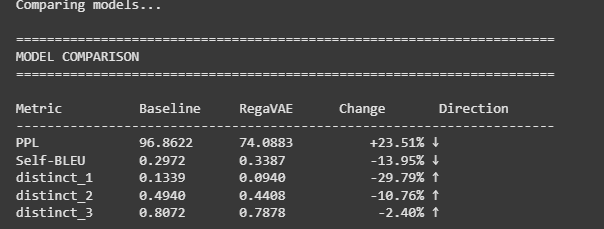

In [114]:
checkpoint_baseline = torch.load('improved_checkpoints/best_model.pth')
model.load_state_dict(checkpoint_baseline['model_state_dict'])
model.eval()
print("Loaded best baseline model.")

checkpoint_regavae = torch.load('regavae_checkpoints/best_model.pth')
regavae_model.load_state_dict(checkpoint_regavae['model_state_dict'])
regavae_model.eval()
print("Loaded best RegaVAE model.")


def generate_from_test(model, test_loader, tokenizer, num_samples=200, source_len=20, gen_len=30,
                       temperature=0.8, top_k=40, top_p=0.9, repetition_penalty=1.1, device='cuda'):

    model.eval()
    generated_texts = []
    test_iter = iter(test_loader)

    with torch.no_grad():
        for _ in range(num_samples):
            try:
                batch = next(test_iter)
            except StopIteration:
                test_iter = iter(test_loader)
                batch = next(test_iter)


            input_ids = batch['input_ids'][0:1].to(device)  # [1, max_length]
            attention_mask = batch['attention_mask'][0:1].to(device)
            original_text = batch['text'][0]  # Full original for reference


            source_ids = input_ids[:, :source_len]
            source_mask = attention_mask[:, :source_len]


            mu_prior, logvar_prior = model.prior_net(source_ids, source_mask)
            z = model.reparameterize(mu_prior, logvar_prior)



            retrieved_ids = None
            retrieval_weights = None
            if hasattr(model, 'use_retrieval') and model.use_retrieval and model.retrieval_db is not None:
                query_vectors = mu_prior.cpu().numpy()
                retrieved_texts, _, weights_np = model.retrieval_db.search(query_vectors, k=5)
                retrieval_weights = torch.tensor(weights_np).to(device)

                encoded_list = [tokenizer(t, max_length=64, padding='max_length', truncation=True, return_tensors='pt')['input_ids'].squeeze(0)
                                for t in retrieved_texts[0]]
                retrieved_ids = torch.stack(encoded_list).unsqueeze(0).to(device)  # [1,5,64]


            generated = source_ids.clone()
            for step in range(gen_len):
                curr_mask = torch.ones(1, generated.size(1), device=device)
                logits = model.decoder(generated, z, curr_mask, retrieved_ids, retrieval_weights) if retrieved_ids is not None else \
                         model.decoder(generated, z, curr_mask)

                next_logits = logits[0, -1, :] / temperature


                if repetition_penalty > 1.0:
                    for token_id in set(generated[0].tolist()):
                        next_logits[token_id] /= repetition_penalty


                if top_k > 0:
                    indices_to_remove = next_logits < torch.topk(next_logits, top_k)[0][-1, None]
                    next_logits[indices_to_remove] = float('-inf')
                if top_p < 1.0:
                    sorted_logits, sorted_indices = torch.sort(next_logits, descending=True)
                    cum_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
                    sorted_indices_to_remove = cum_probs > top_p
                    sorted_indices_to_remove[0] = False
                    indices_to_remove = sorted_indices_to_remove.scatter(0, sorted_indices, sorted_indices_to_remove)
                    next_logits[indices_to_remove] = float('-inf')

                probs = F.softmax(next_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1).unsqueeze(0)
                generated = torch.cat([generated, next_token], dim=1)

                if next_token.item() == tokenizer.eos_token_id:
                    break


            gen_tokens = generated[0, source_len:].cpu().tolist()
            gen_text = tokenizer.decode(gen_tokens, skip_special_tokens=True).strip()
            generated_texts.append(gen_text)

    return generated_texts


baseline_generated = generate_from_test(
    model, test_loader, tokenizer, num_samples=200, source_len=15, gen_len=20,
    temperature=0.8, top_k=40, top_p=0.9, repetition_penalty=1.1, device=device
)


regavae_generated = generate_from_test(
    regavae_model, test_loader, tokenizer, num_samples=200, source_len=15, gen_len=20,
    temperature=0.8, top_k=40, top_p=0.9, repetition_penalty=1.1, device=device
)






print("\nComputing full metrics for baseline...")
baseline_metrics = evaluate_all_metrics(
    model, test_loader, baseline_generated,
    use_retrieval=False, tokenizer=tokenizer
)

print("\nComputing full metrics for RegaVAE...")
regavae_metrics = evaluate_all_metrics(
    regavae_model, test_loader, regavae_generated,
    use_retrieval=True, tokenizer=tokenizer
)

print("\nComparing models...")
comparison = compare_models(baseline_metrics, regavae_metrics)



Loaded best baseline model.
Loaded best RegaVAE model.

Computing full metrics for baseline...
Computing evaluation metrics...
1. Computing Perplexity...


Computing PPL: 100%|██████████| 20/20 [00:01<00:00, 18.06it/s]


Mode: Baseline | Final PPL: 145.86
   PPL: 145.86
2. Computing Self-BLEU...
   Self-BLEU: 0.3645
3. Computing Distinct-n metrics...
   Distinct-1: 0.0876
   Distinct-2: 0.3932
   Distinct-3: 0.7376

Computing full metrics for RegaVAE...
Computing evaluation metrics...
1. Computing Perplexity...


Computing PPL: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


Mode: Retrieval | Final PPL: 66.72
   PPL: 66.72
2. Computing Self-BLEU...
   Self-BLEU: 0.3002
3. Computing Distinct-n metrics...
   Distinct-1: 0.1364
   Distinct-2: 0.5140
   Distinct-3: 0.8011

Comparing models...

MODEL COMPARISON

Metric          Baseline     RegaVAE      Change       Direction
----------------------------------------------------------------------
PPL             145.8580     66.7238          +54.25% ↓
Self-BLEU       0.3645       0.3002           +17.64% ↓
distinct_1      0.0876       0.1364           +55.80% ↑
distinct_2      0.3932       0.5140           +30.71% ↑
distinct_3      0.7376       0.8011            +8.61% ↑
